# Cost subsystem 

### Optimisation

This code will allow you to understand and perform an optimisation on the cost subsystem. The code below is a shortened version of the full code available in thisrepository. The aim of this tutorial is not to demostrate the full potential of this code but to take you thorugh the analysis leading to the solutions for the cost subsystem presented in the report.

In [4]:
import time
import numpy as np
import numpy.ma as ma
import operator as op
import matplotlib.pyplot as plt
from scipy.optimize import minimize, BFGS, LinearConstraint, NonlinearConstraint

Multiple classes were used in common with the light subsytem. This allowed an easier integrationand development of both subsytems for the system level analysis.

The most improtant is MP, which stands for the model parameters. This includes the parameters and constrains- presented in a matrix form - for the optimisation problems. For the cost subsystem specifically, a function containing the non linear constrain is also defined. Centralising the common parameters and constrains allowed to make changes without affecting the functions or model themselves. This was a logic step to ease the future implementation into an app where the variables will be constantly be changing. 

In [5]:
class MP:
    """
    Enum to hold some of the Model Parameters
    """

    """ 
    Global Parameters
    """

    # Discretisation step
    DXY = 0.01

    # Room geometry
    ROOM_LENGTH = 4
    ROOM_WIDTH = 3
    ROOM_HEIGHT = 2.3
    F_PLUG_POSITION = [2.3, 0.05]
    S_PLUG_POSITION = [3.95, 2]


    # Number of lamps
    N_LAMPS = 3

    # Parameters
    LAMP_EFFICIENCY = 0.8
    LAMP_RADII = [0.1, 0.2, 0.1]

    POWER_SCALING_FACTOR = 1
    LAMP_POW = [50, 120, 50]
    LAMP_POW = np.array(LAMP_POW) * POWER_SCALING_FACTOR

    # Albedo
    ALBEDO = 0.5
    BOUNCES = 3

    # Plot parameters
    N_LEVELS = 20
    
    """
    Cost Subsystem
    """

    # Cost
    CABLE_COST = 2
    WORK_COST = 40
    ENERGY_COST = 0.12
    AVG_HOURS_PER_YEAR = float(2500 / 1000)
    INVESTMENT_FACTOR = 3
    # Initial characteristics for lamps
    INITIAL_SOLUTION = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.22234, 0.2])
     
     # Lamp 1: Bed: Bound Constraints (x1, y1)
    G1 = [LAMP_RADII[0], 2.3 - LAMP_RADII[0]]
    G2 = [LAMP_RADII[0], 1.5 - LAMP_RADII[0]]

    # Lamp 2: Floor: Bound Constraints (x2, y2)
    G3 = [0.4 + LAMP_RADII[1], 2.3 - LAMP_RADII[1]]
    G4 = [0.9 + LAMP_RADII[1], 3 - LAMP_RADII[1]]

    # Lamp 3: Desk: Bound Constraints (x3, y3)
    G5 = [2.3 + LAMP_RADII[2], 4 - LAMP_RADII[2]]
    G6 = [1.1 + LAMP_RADII[2], 3 - LAMP_RADII[2]]

    # Efficiency, in a range from 0 to 1
    G7 = [0.2, 1]

    CONSTRAINT_MAT_EXT = [[1, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1]]

    # Add all constrains to limit all variables to 0

    CONSTRAINTS_EXT = [G1, G2, G3, G4, G5, G6, G7]

    # Linear Constraint Bounds
    LOWER_BOUND_EXT = [constraint[0] for constraint in CONSTRAINTS_EXT]
    UPPER_BOUND_EXT = [constraint[1] for constraint in CONSTRAINTS_EXT]


"""
FUNCTIONAL CONSTRAINTS
"""

def functional_constraint(variables):
    c_cable_tot = 0
    total_power = sum(MP.LAMP_POW)

    for i in range(3):
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    c_operation = (total_power / lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST
    c_lamp = (lamp_efficiency / 0.2)
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)

    return c_initial - MP.INVESTMENT_FACTOR * c_operation

The code below defines the cost funtion for cost of lightning a room. The function calculatesinitial and operation costs, which combined constitute the total cost. The variables are the x and y positions for three different lamp and the common efficiency of these lamps.   

In [6]:
def cost_obj_fun(variables):
    """
    Cost objective function. Vars is [x1, y1, x2, y2, x3, y3, e, i]
    Where c is equal for the three lamps and is equal to the the characteristics of lamp composed by price and efficiency
    """
    #Total cable cost is initialised
    c_cable_tot = 0

    # The power is fixed, so the total power is a sum of the power of all the lamps
    total_power = sum(MP.LAMP_POW)

    '''
    There are 7 variables in total
    In a range of 3 - which equals for iterations,  i = 0,1 and 2 will refer to each of the lamps. 
    The code will consider which considers i and i+1 for x, y  
    '''
    #Start the loop to calculate cable length
    for i in range(3):
        #Calcilate total length, including 1.6 m for the height of the lamps in the room.
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        #Calculate the total price
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    # Calculate the operation cost in terms of the efficiency
    c_operation = (total_power/lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST

    #Calculate the lamp cost in terms of the efficiency
    c_lamp = (lamp_efficiency/0.2)
    
    # Calculate total lamp cost
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp
    
    # Calculate work cost 
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST
    
    #Caltulate the initial cost 
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)
    
    #Caltulate total cost 
    c_tot = c_initial + c_operation

    return c_tot




The following code presents the trust region algorithm "trust- constr", which is aprt of the Scypy library. It takes into account the linear and non linear constrains defined in model parameters. An initial guess is defined and the model optimises it. The recommendeed hessian is defined as BFGS. 

In [7]:
class TrustConstrModel:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self):

        # To keep track of the iterations
        self.counter = 0

        # Parameters
        self.name = 'Trust-Constr'
        self.refl = False
        self.save_fig = False
        self.save_log = False
        self.constrained = True

        if self.save_log:
            self.data = []

        if self.constrained:
            self.constraints = (LinearConstraint(MP.CONSTRAINT_MAT_EXT, MP.LOWER_BOUND_EXT, MP.UPPER_BOUND_EXT),
                                NonlinearConstraint(functional_constraint, -np.inf, 0, jac='cs', hess=BFGS()))
        else:
            self.constraints = ()

        print("You are using a trust-constr optimiser.")
        print("Constraints: ", self.constrained)

        time.sleep(1)
        # Objective function. We want to maximise this
        self.result = minimize(self.obj_fun, MP.INITIAL_SOLUTION, method='trust-constr', jac='3-point',
                               constraints=self.constraints, hess=BFGS(exception_strategy='damp_update'))

        # What is the result of the optimisation?
        print(self.result)

    def obj_fun(self, variables):
        """
        Cost objective function. Vars is [x1, y1, x2, y2, x3, y3, c]
        Where c is equal for the three lamps and is equal to the the characteristics
        of lamp composed by price and efficiency
        Call the function cost
        """
        # Calculate current cost
        c_tot = cost_obj_fun(variables)

        print("Iteration: ", self.counter, "Positions and efficiency", variables, "total cost", c_tot)
        self.counter += 1
        return c_tot


In [8]:
model = TrustConstrModel()

You are using a trust-constr optimiser.
Constraints:  True
Iteration:  0 Positions and efficiency [0.68978269 0.98767149 1.78447148 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.8403645467244
Iteration:  1 Positions and efficiency [0.68977663 0.98767149 1.78447148 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.84031610308875
Iteration:  2 Positions and efficiency [0.68978875 0.98767149 1.78447148 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.84041299036
Iteration:  3 Positions and efficiency [0.68978269 0.98766543 1.78447148 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.84031610308875
Iteration:  4 Positions and efficiency [0.68978269 0.98767755 1.78447148 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.84041299036
Iteration:  5 Positions and efficiency [0.68978269 0.98767149 1.78446067 2.79305784 3.66072114 2.22234
 0.2       ] total cost 442.8403213235813
Iteration:  6 Positions and efficiency [0.68978269 0.98767149 1.78448229 

Iteration:  125 Positions and efficiency [0.729151   0.92170603 1.6885619  2.61844318 3.54951485 2.20035737
 0.52588681] total cost 241.66970760757175
Iteration:  126 Positions and efficiency [0.729151   0.92170603 1.68858235 2.61844318 3.54951485 2.20035737
 0.52588681] total cost 241.66978940814457
Iteration:  127 Positions and efficiency [0.729151   0.92170603 1.68857213 2.61842733 3.54951485 2.20035737
 0.52588681] total cost 241.66968508440445
Iteration:  128 Positions and efficiency [0.729151   0.92170603 1.68857213 2.61845904 3.54951485 2.20035737
 0.52588681] total cost 241.66981193131187
Iteration:  129 Positions and efficiency [0.729151   0.92170603 1.68857213 2.61844318 3.54949336 2.20035737
 0.52588681] total cost 241.66970552000714
Iteration:  130 Positions and efficiency [0.729151   0.92170603 1.68857213 2.61844318 3.54953634 2.20035737
 0.52588681] total cost 241.66979149570915
Iteration:  131 Positions and efficiency [0.729151   0.92170603 1.68857213 2.61844318 3.549514

Iteration:  240 Positions and efficiency [0.72202325 0.91436267 1.68491003 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.9202518561233
Iteration:  241 Positions and efficiency [0.72201719 0.91436267 1.68491003 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.9202034124877
Iteration:  242 Positions and efficiency [0.72202931 0.91436267 1.68491003 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.92030029975894
Iteration:  243 Positions and efficiency [0.72202325 0.91435661 1.68491003 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.9202034124877
Iteration:  244 Positions and efficiency [0.72202325 0.91436872 1.68491003 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.92030029975894
Iteration:  245 Positions and efficiency [0.72202325 0.91436267 1.68489983 2.61485717 3.54713562 2.19890467
 0.67584252] total cost 215.9202110445395
Iteration:  246 Positions and efficiency [0.72202325 0.91436267 1.68492023 2.61485717 3.54713562 2

 0.79727717] total cost 202.66704941903396
Iteration:  393 Positions and efficiency [0.7128231  0.90488615 1.68006541 2.6094617  3.54393139 2.19695385
 0.79727717] total cost 202.66695253176272
Iteration:  394 Positions and efficiency [0.7128231  0.90489826 1.68006541 2.6094617  3.54393139 2.19695385
 0.79727717] total cost 202.66704941903396
Iteration:  395 Positions and efficiency [0.7128231  0.90489221 1.68005524 2.6094617  3.54393139 2.19695385
 0.79727717] total cost 202.66696028116004
Iteration:  396 Positions and efficiency [0.7128231  0.90489221 1.68007558 2.6094617  3.54393139 2.19695385
 0.79727717] total cost 202.6670416696366
Iteration:  397 Positions and efficiency [0.7128231  0.90489221 1.68006541 2.6094459  3.54393139 2.19695385
 0.79727717] total cost 202.66693776949245
Iteration:  398 Positions and efficiency [0.7128231  0.90489221 1.68006541 2.6094775  3.54393139 2.19695385
 0.79727717] total cost 202.66706418130423
Iteration:  399 Positions and efficiency [0.7128231 

Iteration:  490 Positions and efficiency [0.70730328 0.89913497 1.67714399 2.60572847 3.54239875 2.1954465
 0.85302489] total cost 197.97026739115796
Iteration:  491 Positions and efficiency [0.70730328 0.89913497 1.67714399 2.60572847 3.5423773  2.19543321
 0.85302489] total cost 197.97019790089658
Iteration:  492 Positions and efficiency [0.70730328 0.89913497 1.67714399 2.60572847 3.5423773  2.19545979
 0.85302489] total cost 197.97025107860173
Iteration:  493 Positions and efficiency [0.70730328 0.89913497 1.67714399 2.60572847 3.5423773  2.1954465
 0.85301884] total cost 197.97068290829017
Iteration:  494 Positions and efficiency [0.70730328 0.89913497 1.67714399 2.60572847 3.5423773  2.1954465
 0.85303095] total cost 197.9697660790061
Iteration:  495 Positions and efficiency [0.70637674 0.89818067 1.6766491  2.60518419 3.54211519 2.19520414
 0.86145547] total cost 197.31927756847745
Iteration:  496 Positions and efficiency [0.70637068 0.89818067 1.6766491  2.60518419 3.54211519 2

Iteration:  573 Positions and efficiency [0.70174073 0.89339231 1.67416857 2.60248548 3.54078302 2.19399164
 0.90049845] total cost 194.48193964604297
Iteration:  574 Positions and efficiency [0.70174073 0.89340442 1.67416857 2.60248548 3.54078302 2.19399164
 0.90049845] total cost 194.48203653331421
Iteration:  575 Positions and efficiency [0.70174073 0.89339836 1.67415844 2.60248548 3.54078302 2.19399164
 0.90049845] total cost 194.48194753827244
Iteration:  576 Positions and efficiency [0.70174073 0.89339836 1.67417871 2.60248548 3.54078302 2.19399164
 0.90049845] total cost 194.48202864108475
Iteration:  577 Positions and efficiency [0.70174073 0.89339836 1.67416857 2.60246972 3.54078302 2.19399164
 0.90049845] total cost 194.48192505274955
Iteration:  578 Positions and efficiency [0.70174073 0.89339836 1.67416857 2.60250123 3.54078302 2.19399164
 0.90049845] total cost 194.48205112660762
Iteration:  579 Positions and efficiency [0.70174073 0.89339836 1.67416857 2.60248548 3.540761

Iteration:  719 Positions and efficiency [0.69340841 0.88479781 1.66970583 2.59764935 3.53837606 2.19181149
 0.95913963] total cost 190.69870171577367
Iteration:  720 Positions and efficiency [0.69249048 0.88384831 1.66921193 2.59711334 3.53810849 2.19157065
 0.96470062] total cost 190.36537785508818
Iteration:  721 Positions and efficiency [0.69248443 0.88384831 1.66921193 2.59711334 3.53810849 2.19157065
 0.96470062] total cost 190.36532941145256
Iteration:  722 Positions and efficiency [0.69249654 0.88384831 1.66921193 2.59711334 3.53810849 2.19157065
 0.96470062] total cost 190.3654262987238
Iteration:  723 Positions and efficiency [0.69249048 0.88384225 1.66921193 2.59711334 3.53810849 2.19157065
 0.96470062] total cost 190.36532941145256
Iteration:  724 Positions and efficiency [0.69249048 0.88385436 1.66921193 2.59711334 3.53810849 2.19157065
 0.96470062] total cost 190.3654262987238
Iteration:  725 Positions and efficiency [0.69249048 0.88384831 1.66920182 2.59711334 3.53810849

Iteration:  823 Positions and efficiency [0.68717045 0.87829369 1.66629254 2.59391304 3.53649839 2.19015883
 0.99175774] total cost 188.78721760832119
Iteration:  824 Positions and efficiency [0.68717045 0.87829369 1.66629254 2.59391304 3.53649839 2.19015883
 0.99176985] total cost 188.78658662077288
Iteration:  825 Positions and efficiency [0.68636174 0.87742698 1.66582417 2.59338543 3.53622795 2.18993734
 0.99451821] total cost 188.62553562681643
Iteration:  826 Positions and efficiency [0.68635569 0.87742698 1.66582417 2.59338543 3.53622795 2.18993734
 0.99451821] total cost 188.62548718318084
Iteration:  827 Positions and efficiency [0.6863678  0.87742698 1.66582417 2.59338543 3.53622795 2.18993734
 0.99451821] total cost 188.62558407045208
Iteration:  828 Positions and efficiency [0.68636174 0.87742093 1.66582417 2.59338543 3.53622795 2.18993734
 0.99451821] total cost 188.62548718318084
Iteration:  829 Positions and efficiency [0.68636174 0.87743304 1.66582417 2.59338543 3.536227

 0.9964576 ] total cost 188.32665569153278
Iteration:  990 Positions and efficiency [0.6763534  0.86718466 1.66016357 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.30620816893736
Iteration:  991 Positions and efficiency [0.67634734 0.86718466 1.66016357 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.30615972530177
Iteration:  992 Positions and efficiency [0.67635946 0.86718466 1.66016357 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.306256612573
Iteration:  993 Positions and efficiency [0.6763534  0.86717861 1.66016357 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.30615972530177
Iteration:  994 Positions and efficiency [0.6763534  0.86719072 1.66016357 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.306256612573
Iteration:  995 Positions and efficiency [0.6763534  0.86718466 1.66015352 2.58757595 3.53301861 2.18734005
 0.99645288] total cost 188.3061679567578
Iteration:  996 Positions and efficiency [0.6763534  0.8

Iteration:  1155 Positions and efficiency [0.66582723 0.85636954 1.65475275 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07790469821992
Iteration:  1156 Positions and efficiency [0.66582118 0.85636954 1.65475275 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07785625458428
Iteration:  1157 Positions and efficiency [0.66583329 0.85636954 1.65475275 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07795314185552
Iteration:  1158 Positions and efficiency [0.66582723 0.85636349 1.65475275 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07785625458428
Iteration:  1159 Positions and efficiency [0.66582723 0.8563756  1.65475275 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07795314185552
Iteration:  1160 Positions and efficiency [0.66582723 0.85636954 1.65474273 2.5816005  3.5301223  2.18460982
 0.99646793] total cost 188.07786461710032
Iteration:  1161 Positions and efficiency [0.66582723 0.85636954 1.65476277 2.5816005  3

 0.99648126] total cost 187.8501485219224
Iteration:  1323 Positions and efficiency [0.65526454 0.8457118  1.64919891 2.5757603  3.52692788 2.18189034
 0.99648126] total cost 187.85005163465115
Iteration:  1324 Positions and efficiency [0.65526454 0.84572391 1.64919891 2.5757603  3.52692788 2.18189034
 0.99648126] total cost 187.8501485219224
Iteration:  1325 Positions and efficiency [0.65526454 0.84571786 1.64918892 2.5757603  3.52692788 2.18189034
 0.99648126] total cost 187.8500601316913
Iteration:  1326 Positions and efficiency [0.65526454 0.84571786 1.64920889 2.5757603  3.52692788 2.18189034
 0.99648126] total cost 187.8501400248822
Iteration:  1327 Positions and efficiency [0.65526454 0.84571786 1.64919891 2.5757447  3.52692788 2.18189034
 0.99648126] total cost 187.85003768869
Iteration:  1328 Positions and efficiency [0.65526454 0.84571786 1.64919891 2.5757759  3.52692788 2.18189034
 0.99648126] total cost 187.85016246788348
Iteration:  1329 Positions and efficiency [0.6552645

Iteration:  1485 Positions and efficiency [0.64464712 0.8351317  1.64363697 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.62242466472713
Iteration:  1486 Positions and efficiency [0.64464106 0.8351317  1.64363697 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.62237622109149
Iteration:  1487 Positions and efficiency [0.64465318 0.8351317  1.64363697 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.62247310836273
Iteration:  1488 Positions and efficiency [0.64464712 0.83512565 1.64363697 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.62237622109149
Iteration:  1489 Positions and efficiency [0.64464712 0.83513776 1.64363697 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.62247310836273
Iteration:  1490 Positions and efficiency [0.64464712 0.8351317  1.64362702 2.56990313 3.52372924 2.17924353
 0.99649446] total cost 187.6223848528519
Iteration:  1491 Positions and efficiency [0.64464712 0.8351317  1.64364692 2.56990313 3.

 0.99651017] total cost 187.35348708648235
Iteration:  1684 Positions and efficiency [0.63209877 0.82260244 1.63712354 2.5629654  3.52004267 2.17612689
 0.99651017] total cost 187.3535839737536
Iteration:  1685 Positions and efficiency [0.63209877 0.82259638 1.63711363 2.5629654  3.52004267 2.17612689
 0.99651017] total cost 187.35349587600976
Iteration:  1686 Positions and efficiency [0.63209877 0.82259638 1.63713346 2.5629654  3.52004267 2.17612689
 0.99651017] total cost 187.35357518422614
Iteration:  1687 Positions and efficiency [0.63209877 0.82259638 1.63712354 2.56294988 3.52004267 2.17612689
 0.99651017] total cost 187.3534734504371
Iteration:  1688 Positions and efficiency [0.63209877 0.82259638 1.63712354 2.56298092 3.52004267 2.17612689
 0.99651017] total cost 187.3535976097988
Iteration:  1689 Positions and efficiency [0.63209877 0.82259638 1.63712354 2.5629654  3.52002135 2.17612689
 0.99651017] total cost 187.35349289920185
Iteration:  1690 Positions and efficiency [0.632

Iteration:  1890 Positions and efficiency [0.61859385 0.80908958 1.63015287 2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06426390256797
Iteration:  1891 Positions and efficiency [0.6185878  0.80908958 1.63015287 2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06421545893238
Iteration:  1892 Positions and efficiency [0.61859991 0.80908958 1.63015287 2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06431234620362
Iteration:  1893 Positions and efficiency [0.61859385 0.80908352 1.63015287 2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06421545893238
Iteration:  1894 Positions and efficiency [0.61859385 0.80909563 1.63015287 2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06431234620362
Iteration:  1895 Positions and efficiency [0.61859385 0.80908958 1.630143   2.55549904 3.51613629 2.1727417
 0.99652662] total cost 187.06422441730223
Iteration:  1896 Positions and efficiency [0.61859385 0.80908958 1.63016274 2.55549904 3.51613

Iteration:  2072 Positions and efficiency [0.60715328 0.79744849 1.62411443 2.54918968 3.51275503 2.16974304
 0.99653954] total cost 186.81679459957758
Iteration:  2073 Positions and efficiency [0.60714722 0.79744243 1.62411443 2.54918968 3.51275503 2.16974304
 0.99653954] total cost 186.81669771230634
Iteration:  2074 Positions and efficiency [0.60714722 0.79745455 1.62411443 2.54918968 3.51275503 2.16974304
 0.99653954] total cost 186.81679459957758
Iteration:  2075 Positions and efficiency [0.60714722 0.79744849 1.6241046  2.54918968 3.51275503 2.16974304
 0.99653954] total cost 186.8167068169381
Iteration:  2076 Positions and efficiency [0.60714722 0.79744849 1.62412427 2.54918968 3.51275503 2.16974304
 0.99653954] total cost 186.81678549494586
Iteration:  2077 Positions and efficiency [0.60714722 0.79744849 1.62411443 2.54917424 3.51275503 2.16974304
 0.99653954] total cost 186.81668440993406
Iteration:  2078 Positions and efficiency [0.60714722 0.79744849 1.62411443 2.54920511 3.

Iteration:  2322 Positions and efficiency [0.59230479 0.78176091 1.61572685 2.54105903 3.5079311  2.16554829
 0.99655294] total cost 186.4877063275262
Iteration:  2323 Positions and efficiency [0.59230479 0.78176091 1.61572685 2.54105903 3.5079311  2.16553518
 0.99654689] total cost 186.48799170116325
Iteration:  2324 Positions and efficiency [0.59230479 0.78176091 1.61572685 2.54105903 3.5079311  2.16553518
 0.996559  ] total cost 186.4873685055814
Iteration:  2325 Positions and efficiency [0.59137124 0.78078515 1.61520665 2.54054705 3.50763116 2.16527763
 0.99655377] total cost 186.46711951134202
Iteration:  2326 Positions and efficiency [0.59136518 0.78078515 1.61520665 2.54054705 3.50763116 2.16527763
 0.99655377] total cost 186.4670710677064
Iteration:  2327 Positions and efficiency [0.59137729 0.78078515 1.61520665 2.54054705 3.50763116 2.16527763
 0.99655377] total cost 186.46716795497764
Iteration:  2328 Positions and efficiency [0.59137124 0.7807791  1.61520665 2.54054705 3.50

 0.99655948] total cost 186.32326698560695
Iteration:  2433 Positions and efficiency [0.58481404 0.77396635 1.6115808  2.53695269 3.50553795 2.16348769
 0.99655948] total cost 186.3231700983357
Iteration:  2434 Positions and efficiency [0.58481404 0.77397846 1.6115808  2.53695269 3.50553795 2.16348769
 0.99655948] total cost 186.32326698560695
Iteration:  2435 Positions and efficiency [0.58481404 0.7739724  1.61157104 2.53695269 3.50553795 2.16348769
 0.99655948] total cost 186.32317950655482
Iteration:  2436 Positions and efficiency [0.58481404 0.7739724  1.61159056 2.53695269 3.50553795 2.16348769
 0.99655948] total cost 186.32325757738784
Iteration:  2437 Positions and efficiency [0.58481404 0.7739724  1.6115808  2.53693733 3.50553795 2.16348769
 0.99655948] total cost 186.32315709236542
Iteration:  2438 Positions and efficiency [0.58481404 0.7739724  1.6115808  2.53696805 3.50553795 2.16348769
 0.99655948] total cost 186.32327999157718
Iteration:  2439 Positions and efficiency [0.5

Iteration:  2567 Positions and efficiency [0.57632846 0.76525982 1.6069621  2.53231031 3.50286613 2.16121048
 0.99656673] total cost 186.13831799447235
Iteration:  2568 Positions and efficiency [0.57632241 0.76525376 1.6069621  2.53231031 3.50286613 2.16121048
 0.99656673] total cost 186.1382211072011
Iteration:  2569 Positions and efficiency [0.57632241 0.76526588 1.6069621  2.53231031 3.50286613 2.16121048
 0.99656673] total cost 186.13831799447235
Iteration:  2570 Positions and efficiency [0.57632241 0.76525982 1.60695237 2.53231031 3.50286613 2.16121048
 0.99656673] total cost 186.1382306272936
Iteration:  2571 Positions and efficiency [0.57632241 0.76525982 1.60697183 2.53231031 3.50286613 2.16121048
 0.99656673] total cost 186.13830847437987
Iteration:  2572 Positions and efficiency [0.57632241 0.76525982 1.6069621  2.53229498 3.50286613 2.16121048
 0.99656673] total cost 186.13820821367773
Iteration:  2573 Positions and efficiency [0.57632241 0.76525982 1.6069621  2.53232565 3.5

Iteration:  2745 Positions and efficiency [0.56488984 0.75372294 1.60088364 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89181257921805
Iteration:  2746 Positions and efficiency [0.56488378 0.75372294 1.60088364 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89176413558243
Iteration:  2747 Positions and efficiency [0.56489589 0.75372294 1.60088364 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89186102285367
Iteration:  2748 Positions and efficiency [0.56488984 0.75371689 1.60088364 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89176413558243
Iteration:  2749 Positions and efficiency [0.56488984 0.753729   1.60088364 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89186102285367
Iteration:  2750 Positions and efficiency [0.56488984 0.75372294 1.60087394 2.52610443 3.49934627 2.15819166
 0.99657619] total cost 185.89177380290624
Iteration:  2751 Positions and efficiency [0.56488984 0.75372294 1.60089333 2.52610443 3

Iteration:  2905 Positions and efficiency [0.5552731  0.74416839 1.59588508 2.52094147 3.49647686 2.15567211
 0.99658386] total cost 185.6866236374005
Iteration:  2906 Positions and efficiency [0.5552731  0.74416839 1.59588508 2.52094147 3.49645568 2.15565906
 0.99658386] total cost 185.68655518499565
Iteration:  2907 Positions and efficiency [0.5552731  0.74416839 1.59588508 2.52094147 3.49645568 2.15568517
 0.99658386] total cost 185.68660739929282
Iteration:  2908 Positions and efficiency [0.5552731  0.74416839 1.59588508 2.52094147 3.49645568 2.15567211
 0.9965778 ] total cost 185.68689286741196
Iteration:  2909 Positions and efficiency [0.5552731  0.74416839 1.59588508 2.52094147 3.49645568 2.15567211
 0.99658991] total cost 185.68626972176668
Iteration:  2910 Positions and efficiency [0.55430741 0.74321536 1.5953883  2.52042641 3.49616887 2.1554195
 0.99658461] total cost 185.66606642312536
Iteration:  2911 Positions and efficiency [0.55430135 0.74321536 1.5953883  2.52042641 3.4

Iteration:  3072 Positions and efficiency [0.54461582 0.73370346 1.59044767 2.51529421 3.49332354 2.15289793
 0.99659204] total cost 185.46103137997915
Iteration:  3073 Positions and efficiency [0.54461582 0.73370346 1.59044767 2.51529421 3.49332354 2.1528849
 0.99658599] total cost 185.46131687524712
Iteration:  3074 Positions and efficiency [0.54461582 0.73370346 1.59044767 2.51529421 3.49332354 2.1528849
 0.9965981 ] total cost 185.46069374281552
Iteration:  3075 Positions and efficiency [0.54364355 0.73275376 1.5899561  2.51478313 3.49304127 2.15263055
 0.99659277] total cost 185.44050815293787
Iteration:  3076 Positions and efficiency [0.5436375  0.73275376 1.5899561  2.51478313 3.49304127 2.15263055
 0.99659277] total cost 185.44045970930227
Iteration:  3077 Positions and efficiency [0.54364961 0.73275376 1.5899561  2.51478313 3.49304127 2.15263055
 0.99659277] total cost 185.44055659657351
Iteration:  3078 Positions and efficiency [0.54364355 0.73274771 1.5899561  2.51478313 3.4

 0.99660064] total cost 185.21512350321825
Iteration:  3252 Positions and efficiency [0.53291974 0.72231717 1.58457311 2.50919164 3.48996247 2.14983598
 0.99660064] total cost 185.21517557583832
Iteration:  3253 Positions and efficiency [0.53291974 0.72231717 1.58457311 2.50919164 3.48996247 2.14982296
 0.99659458] total cost 185.21546110124757
Iteration:  3254 Positions and efficiency [0.53291974 0.72231717 1.58457311 2.50919164 3.48996247 2.14982296
 0.99660669] total cost 185.21483798269895
Iteration:  3255 Positions and efficiency [0.53194272 0.7213689  1.58408565 2.50868624 3.48968487 2.14956694
 0.99660134] total cost 185.19467244768782
Iteration:  3256 Positions and efficiency [0.53193666 0.7213689  1.58408565 2.50868624 3.48968487 2.14956694
 0.99660134] total cost 185.19462400405223
Iteration:  3257 Positions and efficiency [0.53194877 0.7213689  1.58408565 2.50868624 3.48968487 2.14956694
 0.99660134] total cost 185.19472089132347
Iteration:  3258 Positions and efficiency [0.

 0.99660349] total cost 184.94938883450914
Iteration:  3449 Positions and efficiency [0.52020256 0.70998715 1.57825368 2.50266032 3.48638055 2.14648836
 0.9966156 ] total cost 184.9487657303549
Iteration:  3450 Positions and efficiency [0.51922349 0.70903805 1.57776881 2.50216131 3.48610726 2.1462315
 0.99661022] total cost 184.928621732797
Iteration:  3451 Positions and efficiency [0.51921743 0.70903805 1.57776881 2.50216131 3.48610726 2.1462315
 0.99661022] total cost 184.92857328916136
Iteration:  3452 Positions and efficiency [0.51922954 0.70903805 1.57776881 2.50216131 3.48610726 2.1462315
 0.99661022] total cost 184.9286701764326
Iteration:  3453 Positions and efficiency [0.51922349 0.709032   1.57776881 2.50216131 3.48610726 2.1462315
 0.99661022] total cost 184.92857328916136
Iteration:  3454 Positions and efficiency [0.51922349 0.70904411 1.57776881 2.50216131 3.48610726 2.1462315
 0.99661022] total cost 184.9286701764326
Iteration:  3455 Positions and efficiency [0.51922349 0

 0.99661806] total cost 184.68324241769153
Iteration:  3636 Positions and efficiency [0.50747804 0.69763422 1.57196743 2.49620628 3.48284845 2.14315047
 0.99661806] total cost 184.6833185690479
Iteration:  3637 Positions and efficiency [0.50747804 0.69763422 1.57195791 2.49619116 3.48284845 2.14315047
 0.99661806] total cost 184.6832200307161
Iteration:  3638 Positions and efficiency [0.50747804 0.69763422 1.57195791 2.49622139 3.48284845 2.14315047
 0.99661806] total cost 184.68334095602336
Iteration:  3639 Positions and efficiency [0.50747804 0.69763422 1.57195791 2.49620628 3.48282736 2.14315047
 0.99661806] total cost 184.6832383129094
Iteration:  3640 Positions and efficiency [0.50747804 0.69763422 1.57195791 2.49620628 3.48286954 2.14315047
 0.99661806] total cost 184.68332267383002
Iteration:  3641 Positions and efficiency [0.50747804 0.69763422 1.57195791 2.49620628 3.48284845 2.14313749
 0.99661806] total cost 184.68325453786957
Iteration:  3642 Positions and efficiency [0.507

 0.99662437] total cost 184.47897577243575
Iteration:  3792 Positions and efficiency [0.49770966 0.68810328 1.56712021 2.49128013 3.48015623 2.14060341
 0.99662437] total cost 184.47902762142766
Iteration:  3793 Positions and efficiency [0.49770966 0.68810328 1.56712021 2.49128013 3.48015623 2.14059045
 0.99661831] total cost 184.4793132394886
Iteration:  3794 Positions and efficiency [0.49770966 0.68810328 1.56712021 2.49128013 3.48015623 2.14059045
 0.99663042] total cost 184.47869015926446
Iteration:  3795 Positions and efficiency [0.49673446 0.68714854 1.56663647 2.49078871 3.4798879  2.14033506
 0.99662499] total cost 184.4585822369721
Iteration:  3796 Positions and efficiency [0.49672841 0.68714854 1.56663647 2.49078871 3.4798879  2.14033506
 0.99662499] total cost 184.45853379333647
Iteration:  3797 Positions and efficiency [0.49674052 0.68714854 1.56663647 2.49078871 3.4798879  2.14033506
 0.99662499] total cost 184.4586306806077
Iteration:  3798 Positions and efficiency [0.496

Iteration:  3960 Positions and efficiency [0.4860334  0.67662525 1.56131465 2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.23406809230283
Iteration:  3961 Positions and efficiency [0.48602735 0.67662525 1.56131465 2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.23401964866724
Iteration:  3962 Positions and efficiency [0.48603946 0.67662525 1.56131465 2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.23411653593845
Iteration:  3963 Positions and efficiency [0.4860334  0.6766192  1.56131465 2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.23401964866724
Iteration:  3964 Positions and efficiency [0.4860334  0.67663131 1.56131465 2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.23411653593845
Iteration:  3965 Positions and efficiency [0.4860334  0.67662525 1.5613052  2.48538918 3.47694388 2.13753486
 0.9966317 ] total cost 184.2340302744238
Iteration:  3966 Positions and efficiency [0.4860334  0.67662525 1.56132411 2.48538918 3.

Iteration:  4140 Positions and efficiency [0.47442538 0.66510071 1.5555084  2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98935350400757
Iteration:  4141 Positions and efficiency [0.47441933 0.66510071 1.5555084  2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98930506037195
Iteration:  4142 Positions and efficiency [0.47443144 0.66510071 1.5555084  2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98940194764316
Iteration:  4143 Positions and efficiency [0.47442538 0.66509465 1.5555084  2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98930506037195
Iteration:  4144 Positions and efficiency [0.47442538 0.66510676 1.5555084  2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98940194764316
Iteration:  4145 Positions and efficiency [0.47442538 0.66510071 1.55549898 2.47949194 3.47374235 2.13450016
 0.99663885] total cost 183.98931582676647
Iteration:  4146 Positions and efficiency [0.47442538 0.66510071 1.55551782 2.47949194 3

Iteration:  4321 Positions and efficiency [0.46289204 0.6535329  1.54970666 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.7448175115279
Iteration:  4322 Positions and efficiency [0.46290415 0.6535329  1.54970666 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.74491439879915
Iteration:  4323 Positions and efficiency [0.46289809 0.65352684 1.54970666 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.7448175115279
Iteration:  4324 Positions and efficiency [0.46289809 0.65353895 1.54970666 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.74491439879915
Iteration:  4325 Positions and efficiency [0.46289809 0.6535329  1.54969728 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.74482841845116
Iteration:  4326 Positions and efficiency [0.46289809 0.6535329  1.54971604 2.47355939 3.4705446  2.13148396
 0.99664588] total cost 183.7449034918759
Iteration:  4327 Positions and efficiency [0.46289809 0.6535329  1.54970666 2.47354441 3.47

Iteration:  4541 Positions and efficiency [0.44955938 0.63999134 1.54295631 2.46656161 3.46681342 2.127966
 0.99665402] total cost 183.4599139934806
Iteration:  4542 Positions and efficiency [0.44955938 0.63999134 1.54295631 2.46656161 3.46681342 2.12799177
 0.99665402] total cost 183.45996553699743
Iteration:  4543 Positions and efficiency [0.44955938 0.63999134 1.54295631 2.46656161 3.46681342 2.12797888
 0.99664797] total cost 183.46025128385065
Iteration:  4544 Positions and efficiency [0.44955938 0.63999134 1.54295631 2.46656161 3.46681342 2.12797888
 0.99666008] total cost 183.4596282515165
Iteration:  4545 Positions and efficiency [0.4486112  0.6390225  1.54247536 2.46605789 3.46654682 2.12772871
 0.9966546 ] total cost 183.43960151788605
Iteration:  4546 Positions and efficiency [0.44860514 0.6390225  1.54247536 2.46605789 3.46654682 2.12772871
 0.9966546 ] total cost 183.43955307425045
Iteration:  4547 Positions and efficiency [0.44861725 0.6390225  1.54247536 2.46605789 3.466

 0.99666161] total cost 183.1957208235669
Iteration:  4738 Positions and efficiency [0.43728016 0.62738315 1.5367217  2.45996805 3.46334706 2.12472403
 0.99665556] total cost 183.1960066037127
Iteration:  4739 Positions and efficiency [0.43728016 0.62738315 1.5367217  2.45996805 3.46334706 2.12472403
 0.99666767] total cost 183.19538358363167
Iteration:  4740 Positions and efficiency [0.43633977 0.62641222 1.53624395 2.45945664 3.4630804  2.12447322
 0.9966622 ] total cost 183.1753827748809
Iteration:  4741 Positions and efficiency [0.43633372 0.62641222 1.53624395 2.45945664 3.4630804  2.12447322
 0.9966622 ] total cost 183.17533433124527
Iteration:  4742 Positions and efficiency [0.43634583 0.62641222 1.53624395 2.45945664 3.4630804  2.12447322
 0.9966622 ] total cost 183.1754312185165
Iteration:  4743 Positions and efficiency [0.43633977 0.62640616 1.53624395 2.45945664 3.4630804  2.12447322
 0.9966622 ] total cost 183.17533433124527
Iteration:  4744 Positions and efficiency [0.4363

Iteration:  4904 Positions and efficiency [0.42696775 0.61669589 1.53148425 2.45430838 3.46041419 2.12195866
 0.99667416] total cost 182.97206731810286
Iteration:  4905 Positions and efficiency [0.42603367 0.61572362 1.53101024 2.45379012 3.46014766 2.12170641
 0.9966687 ] total cost 182.95209074094373
Iteration:  4906 Positions and efficiency [0.42602761 0.61572362 1.53101024 2.45379012 3.46014766 2.12170641
 0.9966687 ] total cost 182.95204229730814
Iteration:  4907 Positions and efficiency [0.42603972 0.61572362 1.53101024 2.45379012 3.46014766 2.12170641
 0.9966687 ] total cost 182.95213918457938
Iteration:  4908 Positions and efficiency [0.42603367 0.61571757 1.53101024 2.45379012 3.46014766 2.12170641
 0.9966687 ] total cost 182.95204229730814
Iteration:  4909 Positions and efficiency [0.42603367 0.61572968 1.53101024 2.45379012 3.46014766 2.12170641
 0.9966687 ] total cost 182.95213918457938
Iteration:  4910 Positions and efficiency [0.42603367 0.61572362 1.53100097 2.45379012 3

Iteration:  5071 Positions and efficiency [0.4157889  0.60502176 1.52582335 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.72903005056548
Iteration:  5072 Positions and efficiency [0.41580101 0.60502176 1.52582335 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.72912693783672
Iteration:  5073 Positions and efficiency [0.41579495 0.6050157  1.52582335 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.72903005056548
Iteration:  5074 Positions and efficiency [0.41579495 0.60502781 1.52582335 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.72912693783672
Iteration:  5075 Positions and efficiency [0.41579495 0.60502176 1.52581411 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.72904153598586
Iteration:  5076 Positions and efficiency [0.41579495 0.60502176 1.52583259 2.44804856 3.4572182  2.11891884
 0.9966753 ] total cost 182.7291154524163
Iteration:  5077 Positions and efficiency [0.41579495 0.60502176 1.52582335 2.44803373 3.

 0.99668204] total cost 182.50641908262992
Iteration:  5238 Positions and efficiency [0.40562019 0.59430141 1.52069369 2.44223578 3.45429581 2.11610172
 0.99668204] total cost 182.50632219535868
Iteration:  5239 Positions and efficiency [0.40562019 0.59431352 1.52069369 2.44223578 3.45429581 2.11610172
 0.99668204] total cost 182.50641908262992
Iteration:  5240 Positions and efficiency [0.40562019 0.59430746 1.52068448 2.44223578 3.45429581 2.11610172
 0.99668204] total cost 182.50633380502887
Iteration:  5241 Positions and efficiency [0.40562019 0.59430746 1.5207029  2.44223578 3.45429581 2.11610172
 0.99668204] total cost 182.50640747295972
Iteration:  5242 Positions and efficiency [0.40562019 0.59430746 1.52069369 2.44222099 3.45429581 2.11610172
 0.99668204] total cost 182.50631148360424
Iteration:  5243 Positions and efficiency [0.40562019 0.59430746 1.52069369 2.44225057 3.45429581 2.11610172
 0.99668204] total cost 182.50642979438436
Iteration:  5244 Positions and efficiency [0.

Iteration:  5404 Positions and efficiency [0.39550676 0.58358466 1.51563149 2.43635964 3.45138511 2.11324659
 0.99668894] total cost 182.2840409651343
Iteration:  5405 Positions and efficiency [0.39550676 0.58357861 1.51562231 2.43635964 3.45138511 2.11324659
 0.99668894] total cost 182.28395581014894
Iteration:  5406 Positions and efficiency [0.39550676 0.58357861 1.51564067 2.43635964 3.45138511 2.11324659
 0.99668894] total cost 182.2840292328484
Iteration:  5407 Positions and efficiency [0.39550676 0.58357861 1.51563149 2.43634489 3.45138511 2.11324659
 0.99668894] total cost 182.2839335084393
Iteration:  5408 Positions and efficiency [0.39550676 0.58357861 1.51563149 2.4363744  3.45138511 2.11324659
 0.99668894] total cost 182.28405153455805
Iteration:  5409 Positions and efficiency [0.39550676 0.58357861 1.51563149 2.43635964 3.45136422 2.11324659
 0.99668894] total cost 182.28395072208795
Iteration:  5410 Positions and efficiency [0.39550676 0.58357861 1.51563149 2.43635964 3.45

 0.99669685] total cost 182.0617234419269
Iteration:  5571 Positions and efficiency [0.38535658 0.57293417 1.51045581 2.4305171  3.44851733 2.11043479
 0.99669685] total cost 182.06179661345462
Iteration:  5572 Positions and efficiency [0.38535658 0.57293417 1.51044666 2.43050238 3.44851733 2.11043479
 0.99669685] total cost 182.0617011561484
Iteration:  5573 Positions and efficiency [0.38535658 0.57293417 1.51044666 2.43053182 3.44851733 2.11043479
 0.99669685] total cost 182.06181889923312
Iteration:  5574 Positions and efficiency [0.38535658 0.57293417 1.51044666 2.4305171  3.44849644 2.11043479
 0.99669685] total cost 182.06171826301156
Iteration:  5575 Positions and efficiency [0.38535658 0.57293417 1.51044666 2.4305171  3.44853821 2.11043479
 0.99669685] total cost 182.06180179236995
Iteration:  5576 Positions and efficiency [0.38535658 0.57293417 1.51044666 2.4305171  3.44851733 2.11042201
 0.99669685] total cost 182.06173446840725
Iteration:  5577 Positions and efficiency [0.38

Iteration:  5737 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42479315 3.4457078  2.10776313
 0.99670637] total cost 181.8393920181286
Iteration:  5738 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42482252 3.4457078  2.10776313
 0.99670637] total cost 181.83950948463587
Iteration:  5739 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42480784 3.44568694 2.10776313
 0.99670637] total cost 181.8394090207289
Iteration:  5740 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42480784 3.44572867 2.10776313
 0.99670637] total cost 181.83949248203555
Iteration:  5741 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42480784 3.4457078  2.10775036
 0.99670637] total cost 181.83942522445503
Iteration:  5742 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42480784 3.4457078  2.10777589
 0.99670637] total cost 181.83947627830943
Iteration:  5743 Positions and efficiency [0.3750688  0.56246866 1.50494816 2.42480784 3.4

Iteration:  5904 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.44289025 2.10509017
 0.99671605] total cost 181.617358295427
Iteration:  5905 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.44293195 2.10509017
 0.99671605] total cost 181.61744168899241
Iteration:  5906 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.4429111  2.10507742
 0.99671605] total cost 181.61737449765445
Iteration:  5907 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.4429111  2.10510291
 0.99671605] total cost 181.61742548676494
Iteration:  5908 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.4429111  2.10509017
 0.99670999] total cost 181.61771146074688
Iteration:  5909 Positions and efficiency [0.36479953 0.5520053  1.49946496 2.41910294 3.4429111  2.10509017
 0.9967221 ] total cost 181.61708852856077
Iteration:  5910 Positions and efficiency [0.36386687 0.551054   1.49896725 2.41858491 3.4

 0.99672594] total cost 181.39565393092903
Iteration:  6071 Positions and efficiency [0.35454902 0.54153806 1.49399668 2.41341412 3.44013163 2.10240268
 0.99672594] total cost 181.39558680564676
Iteration:  6072 Positions and efficiency [0.35454902 0.54153806 1.49399668 2.41341412 3.44013163 2.10242814
 0.99672594] total cost 181.39563772996974
Iteration:  6073 Positions and efficiency [0.35454902 0.54153806 1.49399668 2.41341412 3.44013163 2.10241541
 0.99671989] total cost 181.39592372835924
Iteration:  6074 Positions and efficiency [0.35454902 0.54153806 1.49399668 2.41341412 3.44013163 2.10241541
 0.996732  ] total cost 181.39530081214536
Iteration:  6075 Positions and efficiency [0.35361813 0.54058604 1.49350024 2.41289823 3.43987997 2.10217216
 0.99672685] total cost 181.37546300122523
Iteration:  6076 Positions and efficiency [0.35361208 0.54058604 1.49350024 2.41289823 3.43987997 2.10217216
 0.99672685] total cost 181.37541455758958
Iteration:  6077 Positions and efficiency [0.

Iteration:  6237 Positions and efficiency [0.34431908 0.531059   1.48854098 2.40775583 3.43737424 2.09975169
 0.99673609] total cost 181.17411992079712
Iteration:  6238 Positions and efficiency [0.34431908 0.531059   1.48854098 2.40775583 3.43737424 2.09973898
 0.99673004] total cost 181.17440594340562
Iteration:  6239 Positions and efficiency [0.34431908 0.531059   1.48854098 2.40775583 3.43737424 2.09973898
 0.99674215] total cost 181.17378304358164
Iteration:  6240 Positions and efficiency [0.34339022 0.53010545 1.48804548 2.40724352 3.43712484 2.09949561
 0.99673703] total cost 181.15397024582347
Iteration:  6241 Positions and efficiency [0.34338416 0.53010545 1.48804548 2.40724352 3.43712484 2.09949561
 0.99673703] total cost 181.15392180218785
Iteration:  6242 Positions and efficiency [0.34339627 0.53010545 1.48804548 2.40724352 3.43712484 2.09949561
 0.99673703] total cost 181.1540186894591
Iteration:  6243 Positions and efficiency [0.34339022 0.53009939 1.48804548 2.40724352 3.

 0.9967405 ] total cost 180.9531696746701
Iteration:  6404 Positions and efficiency [0.33411354 0.52055852 1.48309262 2.40214512 3.43464412 2.09706214
 0.99675261] total cost 180.95254679173127
Iteration:  6405 Positions and efficiency [0.33318718 0.5196025  1.4825974  2.40163807 3.43439747 2.09681885
 0.99674752] total cost 180.9327603973896
Iteration:  6406 Positions and efficiency [0.33318112 0.5196025  1.4825974  2.40163807 3.43439747 2.09681885
 0.99674752] total cost 180.93271195375397
Iteration:  6407 Positions and efficiency [0.33319323 0.5196025  1.4825974  2.40163807 3.43439747 2.09681885
 0.99674752] total cost 180.9328088410252
Iteration:  6408 Positions and efficiency [0.33318718 0.51959644 1.4825974  2.40163807 3.43439747 2.09681885
 0.99674752] total cost 180.93271195375397
Iteration:  6409 Positions and efficiency [0.33318718 0.51960855 1.4825974  2.40163807 3.43439747 2.09681885
 0.99674752] total cost 180.9328088410252
Iteration:  6410 Positions and efficiency [0.3331

Iteration:  6570 Positions and efficiency [0.32301569 0.50906612 1.47714675 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71185404670607
Iteration:  6571 Positions and efficiency [0.32300964 0.50906612 1.47714675 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71180560307045
Iteration:  6572 Positions and efficiency [0.32302175 0.50906612 1.47714675 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71190249034169
Iteration:  6573 Positions and efficiency [0.32301569 0.50906006 1.47714675 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71180560307045
Iteration:  6574 Positions and efficiency [0.32301569 0.50907217 1.47714675 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71190249034169
Iteration:  6575 Positions and efficiency [0.32301569 0.50906612 1.47713781 2.3961014  3.43170329 2.09414497
 0.99675837] total cost 180.71181826752652
Iteration:  6576 Positions and efficiency [0.32301569 0.50906612 1.4771557  2.3961014  3

 0.99676963] total cost 180.49123676105057
Iteration:  6737 Positions and efficiency [0.31289192 0.49848416 1.47168008 2.39065485 3.42904787 2.09147918
 0.99676963] total cost 180.4913336483218
Iteration:  6738 Positions and efficiency [0.31288586 0.4984781  1.47168008 2.39065485 3.42904787 2.09147918
 0.99676963] total cost 180.49123676105057
Iteration:  6739 Positions and efficiency [0.31288586 0.49849021 1.47168008 2.39065485 3.42904787 2.09147918
 0.99676963] total cost 180.4913336483218
Iteration:  6740 Positions and efficiency [0.31288586 0.49848416 1.47167117 2.39065485 3.42904787 2.09147918
 0.99676963] total cost 180.49124955791933
Iteration:  6741 Positions and efficiency [0.31288586 0.49848416 1.471689   2.39065485 3.42904787 2.09147918
 0.99676963] total cost 180.49132085145303
Iteration:  6742 Positions and efficiency [0.31288586 0.49848416 1.47168008 2.39064038 3.42904787 2.09147918
 0.99676963] total cost 180.4912272986799
Iteration:  6743 Positions and efficiency [0.312

Iteration:  6903 Positions and efficiency [0.30281214 0.48783751 1.46617962 2.38532096 3.4264368  2.0888292
 0.99678136] total cost 180.27105968511108
Iteration:  6904 Positions and efficiency [0.30281214 0.48784962 1.46617962 2.38532096 3.4264368  2.0888292
 0.99678136] total cost 180.27115657238232
Iteration:  6905 Positions and efficiency [0.30281214 0.48784357 1.46617074 2.38532096 3.4264368  2.0888292
 0.99678136] total cost 180.271072615211
Iteration:  6906 Positions and efficiency [0.30281214 0.48784357 1.4661885  2.38532096 3.4264368  2.0888292
 0.99678136] total cost 180.27114364228242
Iteration:  6907 Positions and efficiency [0.30281214 0.48784357 1.46617962 2.38530652 3.4264368  2.0888292
 0.99678136] total cost 180.27105035193696
Iteration:  6908 Positions and efficiency [0.30281214 0.48784357 1.46617962 2.38533541 3.4264368  2.0888292
 0.99678136] total cost 180.27116590555647
Iteration:  6909 Positions and efficiency [0.30281214 0.48784357 1.46617962 2.38532096 3.4264160

Iteration:  7070 Positions and efficiency [0.29281462 0.4771304  1.46061457 2.38012291 3.42387576 2.08620542
 0.9967936 ] total cost 180.05137130199
Iteration:  7071 Positions and efficiency [0.29281462 0.4771304  1.46063226 2.38012291 3.42387576 2.08620542
 0.9967936 ] total cost 180.0514420598986
Iteration:  7072 Positions and efficiency [0.29281462 0.4771304  1.46062342 2.3801085  3.42387576 2.08620542
 0.9967936 ] total cost 180.0513490300408
Iteration:  7073 Positions and efficiency [0.29281462 0.4771304  1.46062342 2.38013732 3.42387576 2.08620542
 0.9967936 ] total cost 180.0514643318478
Iteration:  7074 Positions and efficiency [0.29281462 0.4771304  1.46062342 2.38012291 3.42385503 2.08620542
 0.9967936 ] total cost 180.0513652146969
Iteration:  7075 Positions and efficiency [0.29281462 0.4771304  1.46062342 2.38012291 3.42389649 2.08620542
 0.9967936 ] total cost 180.0514481471917
Iteration:  7076 Positions and efficiency [0.29281462 0.4771304  1.46062342 2.38012291 3.4238757

 0.99680838] total cost 179.83192188906793
Iteration:  7237 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37462486 3.42104243 2.08353034
 0.99680838] total cost 179.83182912330486
Iteration:  7238 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37465362 3.42104243 2.08353034
 0.99680838] total cost 179.83194415946292
Iteration:  7239 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37463924 3.42102171 2.08353034
 0.99680838] total cost 179.8318452094507
Iteration:  7240 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37463924 3.42106314 2.08353034
 0.99680838] total cost 179.8319280733171
Iteration:  7241 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37463924 3.42104243 2.08351772
 0.99680838] total cost 179.8318614079377
Iteration:  7242 Positions and efficiency [0.28278114 0.46664758 1.45520391 2.37463924 3.42104243 2.08354296
 0.99680838] total cost 179.83191187483004
Iteration:  7243 Positions and efficiency [0.282

Iteration:  7403 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36910477 3.41814382 2.08084064
 0.99682421] total cost 179.61278963939986
Iteration:  7404 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3.41812312 2.08084064
 0.99682421] total cost 179.61269085889495
Iteration:  7405 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3.41816452 2.08084064
 0.99682421] total cost 179.61277365255177
Iteration:  7406 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3.41814382 2.08082804
 0.99682421] total cost 179.61270705485188
Iteration:  7407 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3.41814382 2.08085324
 0.99682421] total cost 179.61275745659484
Iteration:  7408 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3.41814382 2.08084064
 0.99681816] total cost 179.61304363695737
Iteration:  7409 Positions and efficiency [0.27276758 0.45622954 1.44982506 2.36909042 3

 0.99684082] total cost 179.39400752520373
Iteration:  7570 Positions and efficiency [0.26280247 0.44581786 1.44444743 2.36355892 3.4152634  2.07815238
 0.99684082] total cost 179.39409024859054
Iteration:  7571 Positions and efficiency [0.26280247 0.44581786 1.44444743 2.36355892 3.41524271 2.0781398
 0.99684082] total cost 179.39402371858296
Iteration:  7572 Positions and efficiency [0.26280247 0.44581786 1.44444743 2.36355892 3.41524271 2.07816496
 0.99684082] total cost 179.3940740552113
Iteration:  7573 Positions and efficiency [0.26280247 0.44581786 1.44444743 2.36355892 3.41524271 2.07815238
 0.99683476] total cost 179.39436025473304
Iteration:  7574 Positions and efficiency [0.26280247 0.44581786 1.44444743 2.36355892 3.41524271 2.07815238
 0.99684687] total cost 179.39373752394766
Iteration:  7575 Positions and efficiency [0.26189912 0.44487176 1.44395863 2.36305684 3.41497873 2.07790806
 0.99684237] total cost 179.3741932572703
Iteration:  7576 Positions and efficiency [0.261

Iteration:  7736 Positions and efficiency [0.25289084 0.43541528 1.43907142 2.35804263 3.41233573 2.07545289
 0.99685835] total cost 179.1758514577161
Iteration:  7737 Positions and efficiency [0.25289084 0.43541528 1.43907142 2.35804263 3.41233573 2.07547803
 0.99685835] total cost 179.17590172926228
Iteration:  7738 Positions and efficiency [0.25289084 0.43541528 1.43907142 2.35804263 3.41233573 2.07546546
 0.9968523 ] total cost 179.17618794717424
Iteration:  7739 Positions and efficiency [0.25289084 0.43541528 1.43907142 2.35804263 3.41233573 2.07546546
 0.99686441] total cost 179.17556524469032
Iteration:  7740 Positions and efficiency [0.25199264 0.43447012 1.43858278 2.35754185 3.41207108 2.07522126
 0.99686   ] total cost 179.1560696729552
Iteration:  7741 Positions and efficiency [0.25198659 0.43447012 1.43858278 2.35754185 3.41207108 2.07522126
 0.99686   ] total cost 179.15602122931955
Iteration:  7742 Positions and efficiency [0.2519987  0.43447012 1.43858278 2.35754185 3.4

Iteration:  7903 Positions and efficiency [0.24303883 0.42502395 1.43369731 2.35254014 3.40942067 2.07277981
 0.99687095] total cost 178.95857410908596
Iteration:  7904 Positions and efficiency [0.24303883 0.42502395 1.43369731 2.35254014 3.40942067 2.07277981
 0.99688307] total cost 178.95795143671
Iteration:  7905 Positions and efficiency [0.24214639 0.4240799  1.43320885 2.35204057 3.40915521 2.07253572
 0.99687877] total cost 178.93850923003927
Iteration:  7906 Positions and efficiency [0.24214034 0.4240799  1.43320885 2.35204057 3.40915521 2.07253572
 0.99687877] total cost 178.93846078640365
Iteration:  7907 Positions and efficiency [0.24215245 0.4240799  1.43320885 2.35204057 3.40915521 2.07253572
 0.99687877] total cost 178.9385576736749
Iteration:  7908 Positions and efficiency [0.24214639 0.42407385 1.43320885 2.35204057 3.40915521 2.07253572
 0.99687877] total cost 178.93846078640365
Iteration:  7909 Positions and efficiency [0.24214639 0.42408596 1.43320885 2.35204057 3.409

 0.99690307] total cost 178.74095150721539
Iteration:  8070 Positions and efficiency [0.23236782 0.41370287 1.42783695 2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.72156817230717
Iteration:  8071 Positions and efficiency [0.23236176 0.41370287 1.42783695 2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.72151972867155
Iteration:  8072 Positions and efficiency [0.23237388 0.41370287 1.42783695 2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.7216166159428
Iteration:  8073 Positions and efficiency [0.23236782 0.41369681 1.42783695 2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.72151972867155
Iteration:  8074 Positions and efficiency [0.23236782 0.41370893 1.42783695 2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.7216166159428
Iteration:  8075 Positions and efficiency [0.23236782 0.41370287 1.4278283  2.34655206 3.40622981 2.06985142
 0.9968989 ] total cost 178.7215335875007
Iteration:  8076 Positions and efficiency [0.232

Iteration:  8236 Positions and efficiency [0.22265991 0.40334063 1.42246706 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.50526465879472
Iteration:  8237 Positions and efficiency [0.22267202 0.40334063 1.42246706 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.50536154606596
Iteration:  8238 Positions and efficiency [0.22266597 0.40333457 1.42246706 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.50526465879472
Iteration:  8239 Positions and efficiency [0.22266597 0.40334668 1.42246706 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.50536154606596
Iteration:  8240 Positions and efficiency [0.22266597 0.40334063 1.42245845 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.5052786476923
Iteration:  8241 Positions and efficiency [0.22266597 0.40334063 1.42247568 2.34107556 3.40329432 2.06716836
 0.99692068] total cost 178.5053475571684
Iteration:  8242 Positions and efficiency [0.22266597 0.40334063 1.42246706 2.34106138 3.4

 0.99694445] total cost 178.2898720103305
Iteration:  8403 Positions and efficiency [0.21305186 0.39298865 1.41709906 2.3356102  3.40034917 2.06448655
 0.99694445] total cost 178.28977512305926
Iteration:  8404 Positions and efficiency [0.21305186 0.39300076 1.41709906 2.3356102  3.40034917 2.06448655
 0.99694445] total cost 178.2898720103305
Iteration:  8405 Positions and efficiency [0.21305186 0.39299471 1.41709047 2.3356102  3.40034917 2.06448655
 0.99694445] total cost 178.28978924197975
Iteration:  8406 Positions and efficiency [0.21305186 0.39299471 1.41710764 2.3356102  3.40034917 2.06448655
 0.99694445] total cost 178.28985789141
Iteration:  8407 Positions and efficiency [0.21305186 0.39299471 1.41709906 2.33559605 3.40034917 2.06448655
 0.99694445] total cost 178.28976699397023
Iteration:  8408 Positions and efficiency [0.21305186 0.39299471 1.41709906 2.33562434 3.40034917 2.06448655
 0.99694445] total cost 178.2898801394195
Iteration:  8409 Positions and efficiency [0.213051

Iteration:  8569 Positions and efficiency [0.20353911 0.3826727  1.41173266 2.33015466 3.39739627 2.06180607
 0.99697066] total cost 178.07524393759863
Iteration:  8570 Positions and efficiency [0.20353911 0.38266664 1.41172411 2.33015466 3.39739627 2.06180607
 0.99697066] total cost 178.07516129923178
Iteration:  8571 Positions and efficiency [0.20353911 0.38266664 1.41174121 2.33015466 3.39739627 2.06180607
 0.99697066] total cost 178.07522968869424
Iteration:  8572 Positions and efficiency [0.20353911 0.38266664 1.41173266 2.33014055 3.39739627 2.06180607
 0.99697066] total cost 178.07513905338126
Iteration:  8573 Positions and efficiency [0.20353911 0.38266664 1.41173266 2.33016877 3.39739627 2.06180607
 0.99697066] total cost 178.07525193454472
Iteration:  8574 Positions and efficiency [0.20353911 0.38266664 1.41173266 2.33015466 3.3973757  2.06180607
 0.99697066] total cost 178.07515434840627
Iteration:  8575 Positions and efficiency [0.20353911 0.38266664 1.41173266 2.33015466 3

 0.99699987] total cost 177.86151179081224
Iteration:  8736 Positions and efficiency [0.19414465 0.37235802 1.40637599 2.32470664 3.39444002 2.05912701
 0.99699987] total cost 177.86157992036559
Iteration:  8737 Positions and efficiency [0.19414465 0.37235802 1.40636747 2.32469256 3.39444002 2.05912701
 0.99699987] total cost 177.8614895469683
Iteration:  8738 Positions and efficiency [0.19414465 0.37235802 1.40636747 2.32472071 3.39444002 2.05912701
 0.99699987] total cost 177.8616021642095
Iteration:  8739 Positions and efficiency [0.19414465 0.37235802 1.40636747 2.32470664 3.39441947 2.05912701
 0.99699987] total cost 177.861504745835
Iteration:  8740 Positions and efficiency [0.19414465 0.37235802 1.40636747 2.32470664 3.39446058 2.05912701
 0.99699987] total cost 177.86158696534284
Iteration:  8741 Positions and efficiency [0.19414465 0.37235802 1.40636747 2.32470664 3.39444002 2.05911454
 0.99699987] total cost 177.86152091768926
Iteration:  8742 Positions and efficiency [0.1941

Iteration:  8902 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31924773 3.39148919 2.0564495
 0.99703283] total cost 177.64896303026416
Iteration:  8903 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31927582 3.39148919 2.0564495
 0.99703283] total cost 177.64907538373637
Iteration:  8904 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31926177 3.39146865 2.0564495
 0.99703283] total cost 177.6489781329837
Iteration:  8905 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31926177 3.39150972 2.0564495
 0.99703283] total cost 177.6490602810169
Iteration:  8906 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31926177 3.39148919 2.05643704
 0.99703283] total cost 177.64899430152775
Iteration:  8907 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31926177 3.39148919 2.05646195
 0.99703283] total cost 177.6490441124728
Iteration:  8908 Positions and efficiency [0.18488987 0.3620705  1.40100301 2.31926177 3.391489

Iteration:  9069 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38853987 2.05377364
 0.99707054] total cost 177.43775650993763
Iteration:  9070 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38858091 2.05377364
 0.99707054] total cost 177.43783858703006
Iteration:  9071 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38856039 2.0537612
 0.99707054] total cost 177.4377726754184
Iteration:  9072 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38856039 2.05378608
 0.99707054] total cost 177.43782242154933
Iteration:  9073 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38856039 2.05377364
 0.99706449] total cost 177.43810873100426
Iteration:  9074 Positions and efficiency [0.1758023  0.35180584 1.39563882 2.31381182 3.38856039 2.05377364
 0.9970766 ] total cost 177.43748637084653
Iteration:  9075 Positions and efficiency [0.17498562 0.35087388 1.39515117 2.31331565 3.3

 0.99711432] total cost 177.2281585199051
Iteration:  9236 Positions and efficiency [0.1669184  0.34156578 1.39027488 2.30834076 3.38568517 2.05108702
 0.99711432] total cost 177.22809267550204
Iteration:  9237 Positions and efficiency [0.1669184  0.34156578 1.39027488 2.30834076 3.38568517 2.05111186
 0.99711432] total cost 177.22814235685888
Iteration:  9238 Positions and efficiency [0.1669184  0.34156578 1.39027488 2.30834076 3.38568517 2.05109944
 0.99710827] total cost 177.22842866340093
Iteration:  9239 Positions and efficiency [0.1669184  0.34156578 1.39027488 2.30834076 3.38568517 2.05109944
 0.99712038] total cost 177.22780637384236
Iteration:  9240 Positions and efficiency [0.16612248 0.34063615 1.3897873  2.30784143 3.38542821 2.0508564
 0.99711866] total cost 177.2091424674955
Iteration:  9241 Positions and efficiency [0.16611642 0.34063615 1.3897873  2.30784143 3.38542821 2.0508564
 0.99711866] total cost 177.2090940238599
Iteration:  9242 Positions and efficiency [0.16612

Iteration:  9402 Positions and efficiency [0.15828934 0.33135182 1.38491276 2.30281654 3.38292463 2.04843888
 0.99716593] total cost 177.0203340066895
Iteration:  9403 Positions and efficiency [0.15828934 0.33135182 1.38491276 2.30281654 3.38292463 2.04842648
 0.99715988] total cost 177.02062030399253
Iteration:  9404 Positions and efficiency [0.15828934 0.33135182 1.38491276 2.30281654 3.38292463 2.04842648
 0.99717199] total cost 177.0199980976551
Iteration:  9405 Positions and efficiency [0.15751995 0.3304246  1.38442554 2.30230981 3.38268287 2.04818351
 0.99717109] total cost 177.00152624551467
Iteration:  9406 Positions and efficiency [0.1575139  0.3304246  1.38442554 2.30230981 3.38268287 2.04818351
 0.99717109] total cost 177.00147780187905
Iteration:  9407 Positions and efficiency [0.15752601 0.3304246  1.38442554 2.30230981 3.38268287 2.04818351
 0.99717109] total cost 177.0015746891503
Iteration:  9408 Positions and efficiency [0.15751995 0.33041855 1.38442554 2.30230981 3.38

 0.99722157] total cost 176.81522995633375
Iteration:  9569 Positions and efficiency [0.14999742 0.3211642  1.37955902 2.2971721  3.38040185 2.04575314
 0.99723368] total cost 176.81460784944946
Iteration:  9570 Positions and efficiency [0.14926499 0.32023929 1.37907328 2.29664894 3.38019155 2.04550995
 0.99723381] total cost 176.7963995120827
Iteration:  9571 Positions and efficiency [0.14925894 0.32023929 1.37907328 2.29664894 3.38019155 2.04550995
 0.99723381] total cost 176.79635106844708
Iteration:  9572 Positions and efficiency [0.14927105 0.32023929 1.37907328 2.29664894 3.38019155 2.04550995
 0.99723381] total cost 176.7964479557183
Iteration:  9573 Positions and efficiency [0.14926499 0.32023323 1.37907328 2.29664894 3.38019155 2.04550995
 0.99723381] total cost 176.79635106844708
Iteration:  9574 Positions and efficiency [0.14926499 0.32024534 1.37907328 2.29664894 3.38019155 2.04550995
 0.99723381] total cost 176.7964479557183
Iteration:  9575 Positions and efficiency [0.149

 0.99731102] total cost 176.59404763124422
Iteration:  9743 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29117385 3.37738172 2.04283943
 0.99731102] total cost 176.5941586233631
Iteration:  9744 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29115997 3.37736126 2.04283943
 0.99731102] total cost 176.5940622241414
Iteration:  9745 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29115997 3.37740217 2.04283943
 0.99731102] total cost 176.59414403046594
Iteration:  9746 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29115997 3.37738172 2.04282706
 0.99731102] total cost 176.5940783866614
Iteration:  9747 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29115997 3.37738172 2.0428518
 0.99731102] total cost 176.59412786794593
Iteration:  9748 Positions and efficiency [0.14141913 0.31008735 1.37371525 2.29115997 3.37738172 2.04283943
 0.99730496] total cost 176.5944141159774
Iteration:  9749 Positions and efficiency [0.14141

Iteration:  9976 Positions and efficiency [0.13164226 0.29536384 1.36590942 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31226950563013
Iteration:  9977 Positions and efficiency [0.13165437 0.29536384 1.36590942 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31236639290137
Iteration:  9978 Positions and efficiency [0.13164832 0.29535778 1.36590942 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31226950563013
Iteration:  9979 Positions and efficiency [0.13164832 0.29536989 1.36590942 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31236639290137
Iteration:  9980 Positions and efficiency [0.13164832 0.29536384 1.36590115 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31228486445667
Iteration:  9981 Positions and efficiency [0.13164832 0.29536384 1.36591769 2.28318603 3.37332324 2.03896525
 0.99744435] total cost 176.31235103407485
Iteration:  9982 Positions and efficiency [0.13164832 0.29536384 1.36590942 2.28317221 3

 0.99744917] total cost 176.1734943664934
Iteration:  10152 Positions and efficiency [0.13135697 0.28510109 1.36037567 2.2778339  3.37061488 2.03639834
 0.99744917] total cost 176.17354369146426
Iteration:  10153 Positions and efficiency [0.13135697 0.28510109 1.36037567 2.2778339  3.37061488 2.03638601
 0.99744311] total cost 176.17382990635437
Iteration:  10154 Positions and efficiency [0.13135697 0.28510109 1.36037567 2.2778339  3.37061488 2.03638601
 0.99745522] total cost 176.1732081564807
Iteration:  10155 Positions and efficiency [0.13132996 0.28417007 1.3598735  2.27734681 3.37036833 2.03615111
 0.99744962] total cost 176.16091182047893
Iteration:  10156 Positions and efficiency [0.13132391 0.28417007 1.3598735  2.27734681 3.37036833 2.03615111
 0.99744962] total cost 176.16086337684334
Iteration:  10157 Positions and efficiency [0.13133602 0.28417007 1.3598735  2.27734681 3.37036833 2.03615111
 0.99744962] total cost 176.16096026411458
Iteration:  10158 Positions and efficienc

 0.9974552 ] total cost 176.0098164960267
Iteration:  10340 Positions and efficiency [0.13099804 0.27302447 1.35385065 2.27149594 3.36740499 2.03332695
 0.9974552 ] total cost 176.00973525946873
Iteration:  10341 Positions and efficiency [0.13099804 0.27302447 1.35386705 2.27149594 3.36740499 2.03332695
 0.9974552 ] total cost 176.0098008453134
Iteration:  10342 Positions and efficiency [0.13099804 0.27302447 1.35385885 2.27148218 3.36740499 2.03332695
 0.9974552 ] total cost 176.00971303263032
Iteration:  10343 Positions and efficiency [0.13099804 0.27302447 1.35385885 2.27150969 3.36740499 2.03332695
 0.9974552 ] total cost 176.00982307215185
Iteration:  10344 Positions and efficiency [0.13099804 0.27302447 1.35385885 2.27149594 3.3673846  2.03332695
 0.9974552 ] total cost 176.00972727005595
Iteration:  10345 Positions and efficiency [0.13099804 0.27302447 1.35385885 2.27149594 3.36742539 2.03332695
 0.9974552 ] total cost 176.0098088347262
Iteration:  10346 Positions and efficiency

Iteration:  10568 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26418354 3.36368785 2.02978352
 0.99746273] total cost 175.82126900001953
Iteration:  10569 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26416983 3.36366748 2.02978352
 0.99746273] total cost 175.82117342039334
Iteration:  10570 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26416983 3.36370822 2.02978352
 0.99746273] total cost 175.82125489502766
Iteration:  10571 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26416983 3.36368785 2.02977123
 0.99746273] total cost 175.82118957518725
Iteration:  10572 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26416983 3.36368785 2.02979581
 0.99746273] total cost 175.8212387402338
Iteration:  10573 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.26416983 3.36368785 2.02978352
 0.99745667] total cost 175.82152502416318
Iteration:  10574 Positions and efficiency [0.13055852 0.25916644 1.34636851 2.2641

 0.99747105] total cost 175.63304035032337
Iteration:  10789 Positions and efficiency [0.13008361 0.24540634 1.33890648 2.25683444 3.35995489 2.02622658
 0.99747105] total cost 175.6331372375946
Iteration:  10790 Positions and efficiency [0.13008361 0.24540028 1.33889837 2.25683444 3.35995489 2.02622658
 0.99747105] total cost 175.63305636321016
Iteration:  10791 Positions and efficiency [0.13008361 0.24540028 1.33891459 2.25683444 3.35995489 2.02622658
 0.99747105] total cost 175.6331212247078
Iteration:  10792 Positions and efficiency [0.13008361 0.24540028 1.33890648 2.25682077 3.35995489 2.02622658
 0.99747105] total cost 175.63303412932643
Iteration:  10793 Positions and efficiency [0.13008361 0.24540028 1.33890648 2.2568481  3.35995489 2.02622658
 0.99747105] total cost 175.63314345859152
Iteration:  10794 Positions and efficiency [0.13008361 0.24540028 1.33890648 2.25683444 3.35993455 2.02622658
 0.99747105] total cost 175.63304810185136
Iteration:  10795 Positions and efficienc

 0.9974791 ] total cost 175.4704533237222
Iteration:  10985 Positions and efficiency [0.12963505 0.23355432 1.33245138 2.25047349 3.35670596 2.02313414
 0.9974791 ] total cost 175.4703726054965
Iteration:  10986 Positions and efficiency [0.12963505 0.23355432 1.33246752 2.25047349 3.35670596 2.02313414
 0.9974791 ] total cost 175.47043715467672
Iteration:  10987 Positions and efficiency [0.12963505 0.23355432 1.33245945 2.25045986 3.35670596 2.02313414
 0.9974791 ] total cost 175.4703503695277
Iteration:  10988 Positions and efficiency [0.12963505 0.23355432 1.33245945 2.25048712 3.35670596 2.02313414
 0.9974791 ] total cost 175.47045939064554
Iteration:  10989 Positions and efficiency [0.12963505 0.23355432 1.33245945 2.25047349 3.35668564 2.02313414
 0.9974791 ] total cost 175.47036422732646
Iteration:  10990 Positions and efficiency [0.12963505 0.23355432 1.33245945 2.25047349 3.35672629 2.02313414
 0.9974791 ] total cost 175.47044553284675
Iteration:  10991 Positions and efficiency

 0.99748965] total cost 175.28314617995494
Iteration:  11218 Positions and efficiency [0.12906231 0.21999952 1.32503973 2.24313425 3.35294122 2.01955611
 0.99748359] total cost 175.28343256606644
Iteration:  11219 Positions and efficiency [0.12906231 0.21999952 1.32503973 2.24313425 3.35294122 2.01955611
 0.9974957 ] total cost 175.28281088140025
Iteration:  11220 Positions and efficiency [0.12902163 0.21910071 1.3245457  2.24264509 3.35268966 2.01931723
 0.99749041] total cost 175.27065302563278
Iteration:  11221 Positions and efficiency [0.12901557 0.21910071 1.3245457  2.24264509 3.35268966 2.01931723
 0.99749041] total cost 175.2706045819972
Iteration:  11222 Positions and efficiency [0.12902768 0.21910071 1.3245457  2.24264509 3.35268966 2.01931723
 0.99749041] total cost 175.27070146926843
Iteration:  11223 Positions and efficiency [0.12902163 0.21909465 1.3245457  2.24264509 3.35268966 2.01931723
 0.99749041] total cost 175.2706045819972
Iteration:  11224 Positions and efficienc

Iteration:  11401 Positions and efficiency [0.12849846 0.2083681  1.31862215 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.12115048787848
Iteration:  11402 Positions and efficiency [0.12851057 0.2083681  1.31862215 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.12124737514972
Iteration:  11403 Positions and efficiency [0.12850452 0.20836204 1.31862215 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.12115048787848
Iteration:  11404 Positions and efficiency [0.12850452 0.20837416 1.31862215 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.12124737514972
Iteration:  11405 Positions and efficiency [0.12850452 0.2083681  1.31861417 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.12116699208858
Iteration:  11406 Positions and efficiency [0.12850452 0.2083681  1.31863014 2.23677719 3.34966577 2.0164478
 0.99750023] total cost 175.1212308709396
Iteration:  11407 Positions and efficiency [0.12850452 0.2083681  1.31862215 2.23676364 3

 0.99751468] total cost 174.9348911933933
Iteration:  11628 Positions and efficiency [0.1277679  0.19510425 1.31122765 2.22944889 3.3458757  2.01285405
 0.99751468] total cost 174.93479430612206
Iteration:  11629 Positions and efficiency [0.1277679  0.19511636 1.31122765 2.22944889 3.3458757  2.01285405
 0.99751468] total cost 174.9348911933933
Iteration:  11630 Positions and efficiency [0.1277679  0.1951103  1.31121971 2.22944889 3.3458757  2.01285405
 0.99751468] total cost 174.93481098944045
Iteration:  11631 Positions and efficiency [0.1277679  0.1951103  1.31123559 2.22944889 3.3458757  2.01285405
 0.99751468] total cost 174.93487451007485
Iteration:  11632 Positions and efficiency [0.1277679  0.1951103  1.31122765 2.22943539 3.3458757  2.01285405
 0.99751468] total cost 174.9347887484528
Iteration:  11633 Positions and efficiency [0.1277679  0.1951103  1.31122765 2.22946239 3.3458757  2.01285405
 0.99751468] total cost 174.93489675106252
Iteration:  11634 Positions and efficiency

 0.9975286 ] total cost 174.78618193577233
Iteration:  11818 Positions and efficiency [0.12708524 0.18465911 1.30531821 2.22359103 3.34284041 2.00997404
 0.99752255] total cost 174.78646840656043
Iteration:  11819 Positions and efficiency [0.12708524 0.18465911 1.30531821 2.22359103 3.34284041 2.00997404
 0.99753466] total cost 174.78584678463548
Iteration:  11820 Positions and efficiency [0.12702384 0.18379547 1.30482601 2.22310296 3.34258753 2.00973385
 0.99752988] total cost 174.77378451711076
Iteration:  11821 Positions and efficiency [0.12701778 0.18379547 1.30482601 2.22310296 3.34258753 2.00973385
 0.99752988] total cost 174.77373607347513
Iteration:  11822 Positions and efficiency [0.12702989 0.18379547 1.30482601 2.22310296 3.34258753 2.00973385
 0.99752988] total cost 174.77383296074638
Iteration:  11823 Positions and efficiency [0.12702384 0.18378941 1.30482601 2.22310296 3.34258753 2.00973385
 0.99752988] total cost 174.77373607347513
Iteration:  11824 Positions and efficie

 0.99755349] total cost 174.57617468412295
Iteration:  12068 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.21530392 3.33854723 2.00588681
 0.99755349] total cost 174.57628200084895
Iteration:  12069 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.2152905  3.33852701 2.00588681
 0.99755349] total cost 174.57618790964457
Iteration:  12070 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.2152905  3.33856745 2.00588681
 0.99755349] total cost 174.57626877532732
Iteration:  12071 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.2152905  3.33854723 2.00587467
 0.99755349] total cost 174.57620404937347
Iteration:  12072 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.2152905  3.33854723 2.00589896
 0.99755349] total cost 174.5762526355984
Iteration:  12073 Positions and efficiency [0.12592539 0.17016206 1.2969598  2.2152905  3.33854723 2.00588681
 0.99754744] total cost 174.57653913584332
Iteration:  12074 Positions and efficien

Iteration:  12240 Positions and efficiency [0.12492431 0.1602213  1.29108189 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42868756749456
Iteration:  12241 Positions and efficiency [0.12491826 0.1602213  1.29108189 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42863912385894
Iteration:  12242 Positions and efficiency [0.12493037 0.1602213  1.29108189 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42873601113018
Iteration:  12243 Positions and efficiency [0.12492431 0.16021524 1.29108189 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42863912385894
Iteration:  12244 Positions and efficiency [0.12492431 0.16022735 1.29108189 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42873601113018
Iteration:  12245 Positions and efficiency [0.12492431 0.1602213  1.29107407 2.20941432 3.33552866 2.00299681
 0.99757634] total cost 174.42865629514426
Iteration:  12246 Positions and efficiency [0.12492431 0.1602213  1.29108971 2.209

 0.99760844] total cost 174.26983705191537
Iteration:  12438 Positions and efficiency [0.12361067 0.14983491 1.28476564 2.20300268 3.33226886 1.99986263
 0.99760844] total cost 174.26974016464413
Iteration:  12439 Positions and efficiency [0.12361067 0.14984702 1.28476564 2.20300268 3.33226886 1.99986263
 0.99760844] total cost 174.26983705191537
Iteration:  12440 Positions and efficiency [0.12361067 0.14984096 1.28475786 2.20300268 3.33226886 1.99986263
 0.99760844] total cost 174.2697574889206
Iteration:  12441 Positions and efficiency [0.12361067 0.14984096 1.28477342 2.20300268 3.33226886 1.99986263
 0.99760844] total cost 174.2698197276389
Iteration:  12442 Positions and efficiency [0.12361067 0.14984096 1.28476564 2.20298934 3.33226886 1.99986263
 0.99760844] total cost 174.26973524755027
Iteration:  12443 Positions and efficiency [0.12361067 0.14984096 1.28476564 2.20301602 3.33226886 1.99986263
 0.99760844] total cost 174.26984196900924
Iteration:  12444 Positions and efficienc

 0.99765169] total cost 174.11271344129852
Iteration:  12643 Positions and efficiency [0.12199427 0.14005407 1.27856553 2.19649183 3.32899677 1.99672969
 0.99764563] total cost 174.11299997338523
Iteration:  12644 Positions and efficiency [0.12199427 0.14005407 1.27856553 2.19649183 3.32899677 1.99672969
 0.99765775] total cost 174.11237854966345
Iteration:  12645 Positions and efficiency [0.12185575 0.13933418 1.27809642 2.19598463 3.32874294 1.99648905
 0.99765561] total cost 174.10072676830714
Iteration:  12646 Positions and efficiency [0.1218497  0.13933418 1.27809642 2.19598463 3.32874294 1.99648905
 0.99765561] total cost 174.10067832467152
Iteration:  12647 Positions and efficiency [0.12186181 0.13933418 1.27809642 2.19598463 3.32874294 1.99648905
 0.99765561] total cost 174.10077521194276
Iteration:  12648 Positions and efficiency [0.12185575 0.13932813 1.27809642 2.19598463 3.32874294 1.99648905
 0.99765561] total cost 174.10067832467152
Iteration:  12649 Positions and efficie

Iteration:  12817 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19033355 3.32591496 1.99384828
 0.99770549] total cost 173.9710165963691
Iteration:  12818 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19036008 3.32591496 1.99384828
 0.99770549] total cost 173.97112270473207
Iteration:  12819 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19034681 3.32589482 1.99384828
 0.99770549] total cost 173.97102937069752
Iteration:  12820 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19034681 3.3259351  1.99384828
 0.99770549] total cost 173.9711099304037
Iteration:  12821 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19034681 3.32591496 1.9938362
 0.99770549] total cost 173.97104550323576
Iteration:  12822 Positions and efficiency [0.12019574 0.13183378 1.273015   2.19034681 3.32591496 1.99386035
 0.99770549] total cost 173.97109379786548
Iteration:  12823 Positions and efficiency [0.12019574 0.13183378 1.273015   2.190346

 0.9977333 ] total cost 173.8640479034062
Iteration:  13044 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.3220774  1.99043513
 0.9977333 ] total cost 173.8639547961777
Iteration:  13045 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.32211764 1.99043513
 0.9977333 ] total cost 173.86403526341854
Iteration:  13046 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.32209752 1.99042308
 0.9977333 ] total cost 173.86397092381958
Iteration:  13047 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.32209752 1.99044718
 0.9977333 ] total cost 173.8640191357767
Iteration:  13048 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.32209752 1.99043513
 0.99772724] total cost 173.86430567841109
Iteration:  13049 Positions and efficiency [0.11934806 0.128673   1.26569018 2.18289183 3.32209752 1.99043513
 0.99773935] total cost 173.86368438605842
Iteration:  13050 Positions and efficiency

Iteration:  13234 Positions and efficiency [0.11933054 0.12861789 1.25930723 2.17642441 3.31876133 1.98756226
 0.9977339 ] total cost 173.79956361091422
Iteration:  13235 Positions and efficiency [0.11933054 0.12861183 1.25929961 2.17642441 3.31876133 1.98756226
 0.9977339 ] total cost 173.7994846645682
Iteration:  13236 Positions and efficiency [0.11933054 0.12861183 1.25931486 2.17642441 3.31876133 1.98756226
 0.9977339 ] total cost 173.79954566998902
Iteration:  13237 Positions and efficiency [0.11933054 0.12861183 1.25930723 2.17641123 3.31876133 1.98756226
 0.9977339 ] total cost 173.7994624503231
Iteration:  13238 Positions and efficiency [0.11933054 0.12861183 1.25930723 2.17643759 3.31876133 1.98756226
 0.9977339 ] total cost 173.79956788423414
Iteration:  13239 Positions and efficiency [0.11933054 0.12861183 1.25930723 2.17642441 3.31874123 1.98756226
 0.9977339 ] total cost 173.7994749740625
Iteration:  13240 Positions and efficiency [0.11933054 0.12861183 1.25930723 2.176424

 0.99773441] total cost 173.7449557302366
Iteration:  13401 Positions and efficiency [0.11931576 0.12856037 1.25390966 2.17096564 3.31593815 1.98512673
 0.99773441] total cost 173.74501647381123
Iteration:  13402 Positions and efficiency [0.11931576 0.12856037 1.25390206 2.1709525  3.31593815 1.98512673
 0.99773441] total cost 173.7449335172896
Iteration:  13403 Positions and efficiency [0.11931576 0.12856037 1.25390206 2.17097879 3.31593815 1.98512673
 0.99773441] total cost 173.7450386867582
Iteration:  13404 Positions and efficiency [0.11931576 0.12856037 1.25390206 2.17096564 3.31591807 1.98512673
 0.99773441] total cost 173.74494594299907
Iteration:  13405 Positions and efficiency [0.11931576 0.12856037 1.25390206 2.17096564 3.31595823 1.98512673
 0.99773441] total cost 173.74502626104874
Iteration:  13406 Positions and efficiency [0.11931576 0.12856037 1.25390206 2.17096564 3.31593815 1.98511471
 0.99773441] total cost 173.74496206033484
Iteration:  13407 Positions and efficiency

Iteration:  13650 Positions and efficiency [0.11929306 0.1284815  1.24554253 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.6607703485866
Iteration:  13651 Positions and efficiency [0.119287   0.1284815  1.24554253 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.66072190495098
Iteration:  13652 Positions and efficiency [0.11929911 0.1284815  1.24554253 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.66081879222222
Iteration:  13653 Positions and efficiency [0.11929306 0.12847545 1.24554253 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.66072190495098
Iteration:  13654 Positions and efficiency [0.11929306 0.12848756 1.24554253 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.66081879222222
Iteration:  13655 Positions and efficiency [0.11929306 0.1284815  1.24553498 2.16255343 3.31157628 1.98135056
 0.99773519] total cost 173.66074017928247
Iteration:  13656 Positions and efficiency [0.11929306 0.1284815  1.24555007 2.1625

Iteration:  13900 Positions and efficiency [0.11927187 0.12840812 1.23767056 2.15466108 3.30749401 1.97777931
 0.99773591] total cost 173.58161214826256
Iteration:  13901 Positions and efficiency [0.11927187 0.12840812 1.23767056 2.15466108 3.30747398 1.97776734
 0.99773591] total cost 173.58154813904136
Iteration:  13902 Positions and efficiency [0.11927187 0.12840812 1.23767056 2.15466108 3.30747398 1.97779129
 0.99773591] total cost 173.58159604445154
Iteration:  13903 Positions and efficiency [0.11927187 0.12840812 1.23767056 2.15466108 3.30747398 1.97777931
 0.99772986] total cost 173.5818827382535
Iteration:  13904 Positions and efficiency [0.11927187 0.12840812 1.23767056 2.15466108 3.30747398 1.97777931
 0.99774197] total cost 173.58126145011266
Iteration:  13905 Positions and efficiency [0.11927055 0.12840357 1.2371785  2.15416856 3.30721772 1.97755549
 0.99773596] total cost 173.57662427222752
Iteration:  13906 Positions and efficiency [0.1192645  0.12840357 1.2371785  2.1541

 0.99773664] total cost 173.5023880192102
Iteration:  14134 Positions and efficiency [0.11925089 0.12834173 1.22979784 2.14679049 3.30337577 1.9741886
 0.99773664] total cost 173.50248490648144
Iteration:  14135 Positions and efficiency [0.11925089 0.12833568 1.22979039 2.14679049 3.30337577 1.9741886
 0.99773664] total cost 173.50240667490672
Iteration:  14136 Positions and efficiency [0.11925089 0.12833568 1.22980528 2.14679049 3.30337577 1.9741886
 0.99773664] total cost 173.50246625078495
Iteration:  14137 Positions and efficiency [0.11925089 0.12833568 1.22979784 2.14677749 3.30337577 1.9741886
 0.99773664] total cost 173.50238446367769
Iteration:  14138 Positions and efficiency [0.11925089 0.12833568 1.22979784 2.14680349 3.30337577 1.9741886
 0.99773664] total cost 173.50248846201399
Iteration:  14139 Positions and efficiency [0.11925089 0.12833568 1.22979784 2.14679049 3.30335577 1.9741886
 0.99773664] total cost 173.50239645596275
Iteration:  14140 Positions and efficiency [0.

 0.99773718] total cost 173.44315585967843
Iteration:  14317 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.14088717 3.3003051  1.97148187
 0.99773718] total cost 173.4430743582286
Iteration:  14318 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.1409131  3.3003051  1.97148187
 0.99773718] total cost 173.44317807121485
Iteration:  14319 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.14090014 3.30028512 1.97148187
 0.99773718] total cost 173.44308624502725
Iteration:  14320 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.14090014 3.30032509 1.97148187
 0.99773718] total cost 173.44316618441619
Iteration:  14321 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.14090014 3.3003051  1.97146993
 0.99773718] total cost 173.44310233828438
Iteration:  14322 Positions and efficiency [0.1192353  0.12828198 1.22389479 2.14090014 3.3003051  1.97149381
 0.99773718] total cost 173.44315009115905
Iteration:  14323 Positions and efficien

Iteration:  14483 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.13552194 3.29749256 1.96899019
 0.99773767] total cost 173.38884157462633
Iteration:  14484 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.135509   3.29747259 1.96899019
 0.99773767] total cost 173.38874991308433
Iteration:  14485 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.135509   3.29751253 1.96899019
 0.99773767] total cost 173.3888297843483
Iteration:  14486 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.135509   3.29749256 1.96897826
 0.99773767] total cost 173.38876600245553
Iteration:  14487 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.135509   3.29749256 1.96900211
 0.99773767] total cost 173.38881369497707
Iteration:  14488 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.135509   3.29749256 1.96899019
 0.99773161] total cost 173.38910049381394
Iteration:  14489 Positions and efficiency [0.11922112 0.12823325 1.21848606 2.1355

Iteration:  14703 Positions and efficiency [0.11920196 0.12816148 1.21111587 2.12816878 3.29366042 1.96557635
 0.99773833] total cost 173.31469474254595
Iteration:  14704 Positions and efficiency [0.11920196 0.12817359 1.21111587 2.12816878 3.29366042 1.96557635
 0.99773833] total cost 173.3147916298172
Iteration:  14705 Positions and efficiency [0.11920196 0.12816753 1.21110854 2.12816878 3.29366042 1.96557635
 0.99773833] total cost 173.31471385075352
Iteration:  14706 Positions and efficiency [0.11920196 0.12816753 1.21112321 2.12816878 3.29366042 1.96557635
 0.99773833] total cost 173.31477252160965
Iteration:  14707 Positions and efficiency [0.11920196 0.12816753 1.21111587 2.12815589 3.29366042 1.96557635
 0.99773833] total cost 173.3146916380652
Iteration:  14708 Positions and efficiency [0.11920196 0.12816753 1.21111587 2.12818166 3.29366042 1.96557635
 0.99773833] total cost 173.31479473429795
Iteration:  14709 Positions and efficiency [0.11920196 0.12816753 1.21111587 2.12816

Iteration:  14900 Positions and efficiency [0.1191855  0.12811124 1.20472747 2.1218165  3.29034172 1.96260308
 0.9977389 ] total cost 173.25058530397217
Iteration:  14901 Positions and efficiency [0.1191855  0.12811124 1.20474206 2.1218165  3.29034172 1.96260308
 0.9977389 ] total cost 173.25064366570427
Iteration:  14902 Positions and efficiency [0.1191855  0.12811124 1.20473477 2.12180366 3.29034172 1.96260308
 0.9977389 ] total cost 173.25056309058544
Iteration:  14903 Positions and efficiency [0.1191855  0.12811124 1.20473477 2.12182935 3.29034172 1.96260308
 0.9977389 ] total cost 173.25066587909103
Iteration:  14904 Positions and efficiency [0.1191855  0.12811124 1.20473477 2.1218165  3.29032179 1.96260308
 0.9977389 ] total cost 173.25057463580941
Iteration:  14905 Positions and efficiency [0.1191855  0.12811124 1.20473477 2.1218165  3.29036164 1.96260308
 0.9977389 ] total cost 173.25065433386703
Iteration:  14906 Positions and efficiency [0.1191855  0.12811124 1.20473477 2.121

Once the optimised solution had been obtained and the minimiser has returned a True solution, this is plotted in a visual way. In order to plot the cables plot distribution function is used. In this function the cables are plotted connecting them to the nearest plug. The cost subsystem integrates the cable visualisation into the light subsystem's visualisation, in order for the the cables to also be connected to the lights. 

To be able to plot the lights with the variable position given by the cost function, the instensity distribution function and room class need to be run first.

In [7]:
def get_intensity_distr(lamp_locs, refl=False):
    """
    Calculates the intensity distribution within a room with n number of light sources
    """

    room = Room(MP.ROOM_LENGTH, MP.ROOM_WIDTH)

    # No reflections
    if not refl:

        for i in range(MP.N_LAMPS):
            # Multiply by discretisation step to be in metres
            distance_to_lamp_n = ((room.xx - lamp_locs[2 * i]) ** 2 + (room.yy - lamp_locs[2 * i + 1]) ** 2)

            # Take out the value that are less than a radius away from the light source
            distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[i])

            if i == 0:
                # Initialise the light intensity array
                light_intensity = np.zeros_like(distance_to_lamp_n_filtered)

            # Find light intensity distribution
            light_intensity_n = ((MP.LAMP_EFFICIENCY * MP.LAMP_POW[i]) /
                                 (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

            light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates

    # With reflections
    elif refl:

        initialised = False

        # The first loop takes care of wall reflections
        for i in range(- MP.BOUNCES // 2, MP.BOUNCES // 2 + 1):
            # The second loop takes care of the three different lamps
            for j in range(MP.N_LAMPS):

                x_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_LENGTH - lamp_locs[2 * j])
                y_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j + 1] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_WIDTH - lamp_locs[2 * j + 1])

                distance_to_lamp_n = ((room.xx - (x_jk - MP.ROOM_LENGTH * i)) ** 2 +
                                      (room.yy - (y_jk - MP.ROOM_WIDTH * i)) ** 2)

                # Take out the value that are less than a radius away from the light source
                distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[j])

                # Initialise the light intensity array
                if not initialised:
                    light_intensity = np.zeros_like(distance_to_lamp_n_filtered)
                    initialised = True

                # Find light intensity distribution
                light_intensity_n = ((MP.ALBEDO ** (abs(2 * i))) * (MP.LAMP_EFFICIENCY * MP.LAMP_POW[j]) /
                                     (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

                # Increment light intensity array
                light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates

class Room:
    """
    The Room class contains the space in which the lighting optimisation will take place
    """

    def __init__(self, length, width):

        self.x = np.arange(0, length, MP.DXY)
        self.y = np.arange(0, width, MP.DXY)
        self.xx, self.yy = np.meshgrid(self.x, self.y, sparse=True)


In [9]:
class PlotTestDistribution:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self,
                 lamp_locs = (1, 1, 1.5, 2, 3, 2.5),
                 name='',
                 refl=False,
                 save_fig=False,
                 fig_name='',
                 constrained=False,
                 cost_subsystem=False,
                 weight=-1.0):

        # These cannot be taken from the enum, as they vary upon each instatiation
        self.lamp_locs = lamp_locs
        self.name = name
        self.refl = refl
        self.save_fig = save_fig
        self.fig_name = fig_name
        self.constrained = constrained
        self.cost_subsystem = cost_subsystem
        self.weight = weight

        # Define plugs position
        self.firstplug_position = MP.F_PLUG_POSITION
        self.secondplug_position = MP.S_PLUG_POSITION

        # Plot
        if not self.cost_subsystem:
            self.plot_intensity_distr()
        else:
            self.plot_cable_distribution()

    def plot_intensity_distr(self):
        """
        Calculates the intensity distribution within a room with n number of light sources
        """

        light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)

        # Fill masked areas (lamps) with maximum value
        light_intensity = ma.filled(light_intensity, np.amax(light_intensity))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        # Plot background image of room
        if not self.constrained:
            img = plt.imread("../classes/room_outline.png")
        else:
            img = plt.imread("../classes/room_outline_constr.png")

        ax.imshow(img, extent=[0, MP.ROOM_LENGTH / MP.DXY, 0, MP.ROOM_WIDTH / MP.DXY])

        # Plot intensity distribution
        ax.contourf(light_intensity, MP.N_LEVELS, cmap='plasma', alpha=0.75, antialiased=True)

        # Plot global minimum
        ax.plot(minimum_coordinates[1], minimum_coordinates[0], 'ro', markersize=12)

        # Layout & Titles
        plt.suptitle(self.name + " Optimisation", fontweight='bold')

        plt.title("Reflections: " + str(self.refl) + ", Constraints: " + str(self.constrained)
                  + ", Minimum: " + str(round(minimum, 2)), fontsize='large')

        plt.xlabel('Room X-Position (cm)')
        plt.ylabel('Room Y-Position (cm)')

        # Export figure
        if self.save_fig:
            plt.savefig(self.fig_name + str(self.refl) + str(self.constrained) + '.svg', format='svg', dpi=1200)

        # Show figure

        plt.show()

    def plot_cable_distribution(self):
        """
               Calculates the intensity distribution within a room with n number of light sources
               """

        #light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)
        light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)
        total_cost = cost_obj_fun(self.lamp_locs)

        # Fill masked areas (lamps) with maximum value
        light_intensity = ma.filled(light_intensity, np.amax(light_intensity))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        # Plot background image of room
        if not self.constrained:
            img = plt.imread("../classes/room_outline.png")
        else:
            img = plt.imread("../classes/room_outline_constr.png")

        ax.imshow(img, extent=[0, MP.ROOM_LENGTH / MP.DXY, 0, MP.ROOM_WIDTH / MP.DXY])

        # Plot intensity distribution
        ax.contourf(light_intensity, MP.N_LEVELS, cmap='plasma', alpha=0.75, antialiased=True)

        # Plot global minimum
        ax.plot(minimum_coordinates[1], minimum_coordinates[0], 'ro', markersize=12)


        # plot cost
        for i in range(MP.N_LAMPS):

            lamp_position = [self.lamp_locs[2 * i], self.lamp_locs[2 * i + 1]]
            # distance to first plug and second plang
            d_fp = list(map(op.sub, lamp_position, self.firstplug_position))
            d_sp = list(map(op.sub, lamp_position, self.secondplug_position))

            # therefore cable length for L shape
            l_fp = (abs(d_fp[0]) + abs(d_fp[1]))
            l_sp = (abs(d_sp[0]) + abs(d_sp[1]))

            #print("cable length to plug 1: ", l_fp)
            #print("cable length to plug 2: ", l_sp)

            # Seems to be x1, x2,y1,y2 - look into this
            if l_fp <= l_sp:
                plt.plot([100 * self.firstplug_position[0], 100 * self.lamp_locs[2 * i]],
                         [100 * self.firstplug_position[1], 100 * self.firstplug_position[1]], "grey")
                plt.plot([100 * self.lamp_locs[2 * i], 100 * self.lamp_locs[2 * i]],
                         [100 * self.firstplug_position[1], 100 * self.lamp_locs[2 * i + 1]], "grey")
            else:
                plt.plot([100 * self.secondplug_position[0], 100 * self.lamp_locs[2 * i]],
                         [100 * self.secondplug_position[1], 100 * self.secondplug_position[1]], "grey")
                plt.plot([100 * self.lamp_locs[2 * i], 100 * self.lamp_locs[2 * i]],
                         [100 * self.secondplug_position[1], 100 * self.lamp_locs[2 * i + 1]], "grey")


        # Layout & Titles
        plt.suptitle(self.name + " Optimisation", fontweight='bold')

        if self.weight <= 0.0:
            plt.title("Constraints: " + str(self.constrained) + ", Minimum: " + str(round(minimum, 2)) +
                      ", Cost: " + str(round(total_cost, 2)), fontsize='large')
        else:
            plt.title("Constraints: " + str(self.constrained) + ", Minimum: " + str(round(minimum, 2)) +
                      ", Cost: " + str(round(total_cost, 2)) + " Weight (Light): " + str(self.weight), fontsize='large')

        plt.xlabel('Room X-Position (cm)')
        plt.ylabel('Room Y-Position (cm)')
        # Export figure
        if self.save_fig:
            plt.savefig('../plots/' + self.fig_name + str(self.refl) + str(self.constrained) + str(self.cost_subsystem) + 
            	'.svg', format='svg', dpi=1200)

        # Show figure
        plt.show()


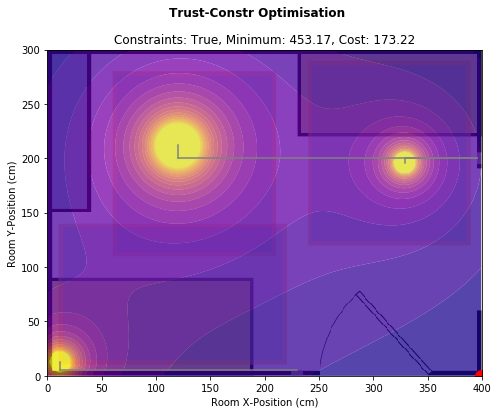

In [10]:
PlotTestDistribution(model.result.x, model.name, refl=model.refl, save_fig=model.save_fig, fig_name=model.name,
                         constrained=model.constrained, cost_subsystem=True)